![](https://raw.githubusercontent.com/FrankFeng-23/SPREAD/master/images/sample_images_compressed-min.png)

## Train custom instance segmentation model using Detectron2 on the SPREAD dataset

##### https://github.com/FrankFeng-23/SPREAD
##### https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4977986
##### https://zenodo.org/records/14515915

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
if torch.cuda.is_available:
    devices       = [d for d in range(torch.cuda.device_count())]
    device_names  = [torch.cuda.get_device_name(d) for d in devices]
    print(f'{device_names}')
else:
    print('WARNING: CUDA not available!')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0
torch:  2.5 ; cuda:  cu124
detectron2: 0.6
['NVIDIA RTX A6000', 'NVIDIA RTX A6000']


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#### Replacement for Colab `cv2_imshow()` found here: https://gist.github.com/lalanikarim/df44bac00918ce8efdfc438c2d73592d

In [3]:
import numpy as np 
import cv2
# comment the original import from google.colab.patch
# from google.colab.patches import cv2_imshow 

# import pytplot from matplotlib if not already imported
import matplotlib.pyplot as plt

# for inline plot rendering
%matplotlib inline

def cv2_imshow(img):
    # set appropriate figure size in case it is too small or too large. Don't worry about it being square.
    plt.figure(figsize=(10,10))
    try:
        # try simple BGR 2 RGB conversion so pyplot can show the image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    except:
        # this is for a special case in case the above doesn't work after applying convolutions
        plt.imshow(cv2.cvtColor(np.uint8(np.absolute(img)), cv2.COLOR_BGR2RGB))
    plt.show()

The default models are trained on the COCO dataset (generic natural images) so let us go ahead and load a generic image to see if detectron is working. **We will run a pre-trained model on this image.**

--2025-01-14 19:37:13--  https://hips.hearstapps.com/hmg-prod/images/white-kitchen-tile-floor-663e73179c3c4.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.128.155, 151.101.192.155, 151.101.0.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.128.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564946 (2.4M) [image/jpeg]
Saving to: ‘/tmp/kitchen.jpg’

/tmp/kitchen.jpg    100%[===================>]   2.45M  9.90MB/s    in 0.2s    

2025-01-14 19:37:13 (9.90 MB/s) - ‘/tmp/kitchen.jpg’ saved [2564946/2564946]



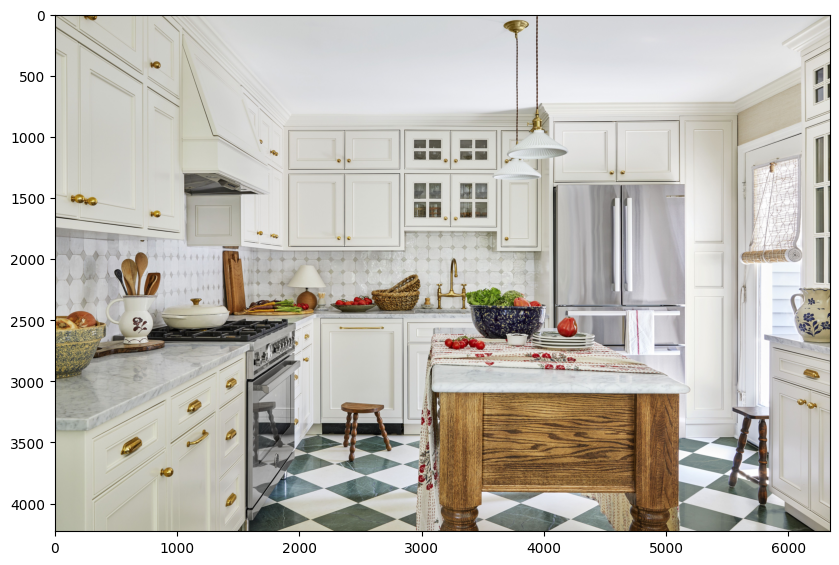

In [4]:
fn = "/tmp/kitchen.jpg"
!wget --user-agent='Mozilla 5.0' 'https://hips.hearstapps.com/hmg-prod/images/white-kitchen-tile-floor-663e73179c3c4.jpg' --output-document={fn}
kitchen = cv2.imread(fn)
cv2_imshow(kitchen)

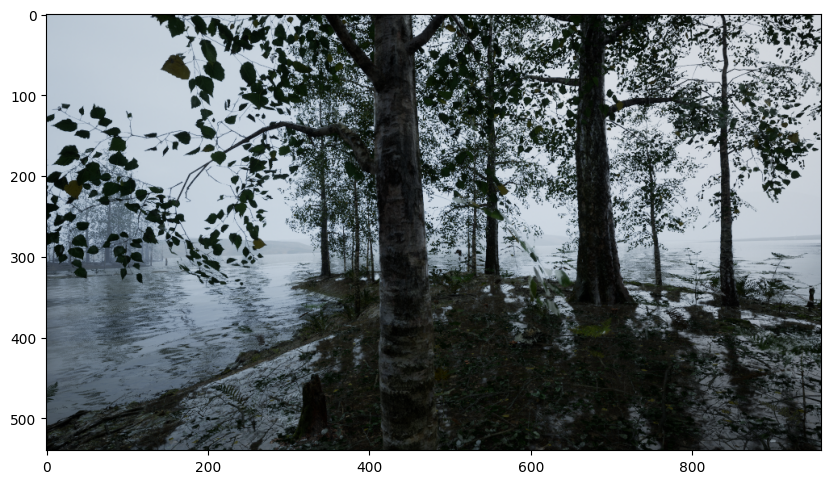

In [5]:
fn   = '/mnt/raid1/dataset/spread/spread-v2/birch-forest/rgb/Tree10011_1720527021.png'
tree = cv2.imread(fn)
cv2_imshow(tree)

#### Create a detectron2 config and a detectron2 DefaultPredictor to run inference on the images

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(kitchen)

[01/14 19:37:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([44, 69, 56, 44, 44, 45, 60, 56, 45, 75, 45, 72, 41, 44, 47, 45, 58, 45,
        47, 72, 47, 46, 45], device='cuda:0')
Boxes(tensor([[6.5815e+02, 1.9479e+03, 7.6059e+02, 2.2956e+03],
        [7.9914e+02, 2.4244e+03, 1.9963e+03, 3.9455e+03],
        [2.3403e+03, 3.1646e+03, 2.7578e+03, 3.6395e+03],
        [4.8495e+02, 2.0909e+03, 5.8961e+02, 2.3047e+03],
        [5.4653e+02, 2.0054e+03, 6.7607e+02, 2.3027e+03],
        [5.5457e-01, 2.4994e+03, 4.1767e+02, 2.9753e+03],
        [2.9884e+03, 2.6632e+03, 5.1691e+03, 4.1879e+03],
        [5.5037e+03, 3.1771e+03, 5.8511e+03, 4.0149e+03],
        [2.2754e+03, 2.3646e+03, 2.6382e+03, 2.4396e+03],
        [6.0042e+03, 2.2164e+03, 6.3410e+03, 2.6818e+03],
        [3.3910e+03, 2.3489e+03, 4.0171e+03, 2.6853e+03],
        [4.1557e+03, 1.3937e+03, 5.1730e+03, 3.6036e+03],
        [4.2928e+02, 2.3030e+03, 8.3838e+02, 2.6952e+03],
        [7.2964e+02, 2.1157e+03, 8.5757e+02, 2.2967e+03],
        [1.9744e+03, 2.2680e+03, 2.1491e+03, 2.4199e+03]

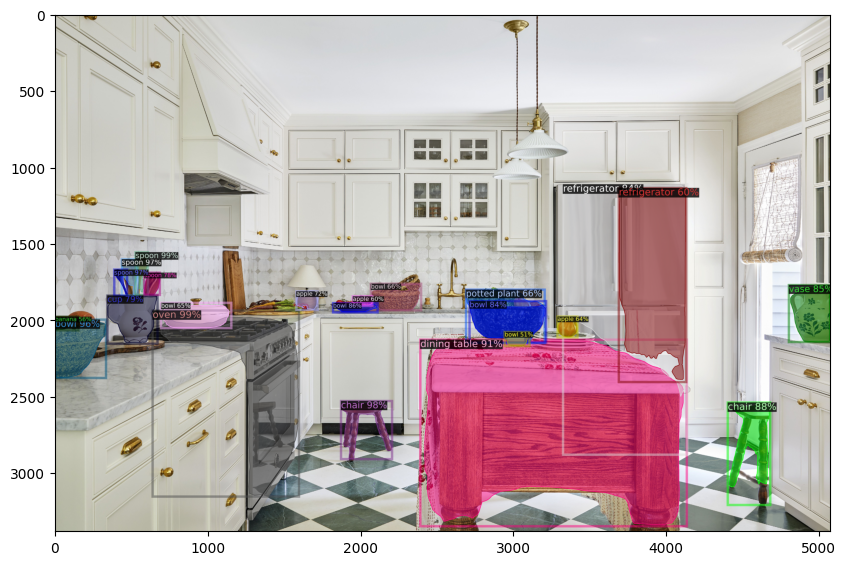

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(kitchen[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

#### Now that we know the model is working on a generic image, let's test the same model on one image from the SPREAD dataset...

Unfortunately the model __mask_rcnn_R_50_FPN_3x__ [has not been trained on trees](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda), so we can't expect great results.

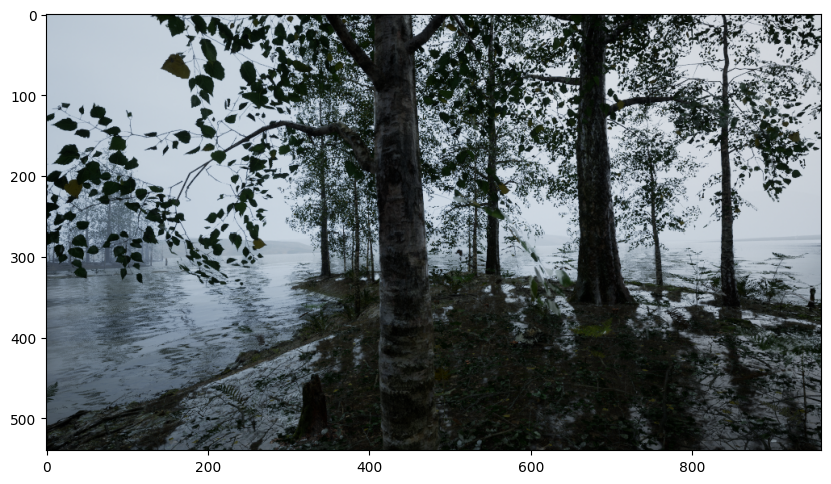

In [9]:
sci_outputs = predictor(tree)
sci_v = Visualizer(tree[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])

No detection at all. Now let's try to fine-tune one of the pretrained models with the SPREAD dataset...

# Train on a custom dataset

Import the necessary function to register datasets in the COCO format. We'll register both the training, validation and test sets. Please note that we are working with training and validation data that is already in the COCO format and that has been merged in a single JSON file (per each set) that describes all the annotations, including segmentation, from all the training images.

In [10]:
from detectron2.data.datasets import register_coco_instances
spread_dir = '/mnt/raid1/dataset/spread/spread-v2'
register_coco_instances("spread_train", {}, f"{spread_dir}/train.json", "/mnt/raid1/dataset/spread/spread-v2-coco")
register_coco_instances("spread_valid", {}, f"{spread_dir}/valid.json", "/mnt/raid1/dataset/spread/spread-v2-coco")
register_coco_instances("spread_test" , {}, f"{spread_dir}/test.json" , "/mnt/raid1/dataset/spread/spread-v2-coco")

Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [11]:
train_metadata      = MetadataCatalog.get("spread_train")
train_dataset_dicts = DatasetCatalog.get ("spread_train")

[01/14 19:37:37 d2.data.datasets.coco]: Loading /mnt/raid1/dataset/spread/spread-v2/train.json takes 17.36 seconds.
[01/14 19:37:37 d2.data.datasets.coco]: Loaded 8356 images in COCO format from /mnt/raid1/dataset/spread/spread-v2/train.json


In [12]:
val_metadata        = MetadataCatalog.get("spread_valid")
val_dataset_dicts   = DatasetCatalog.get ("spread_valid")

[01/14 19:37:44 d2.data.datasets.coco]: Loading /mnt/raid1/dataset/spread/spread-v2/valid.json takes 5.75 seconds.
[01/14 19:37:44 d2.data.datasets.coco]: Loaded 3042 images in COCO format from /mnt/raid1/dataset/spread/spread-v2/valid.json


In [13]:
test_metadata        = MetadataCatalog.get("spread_test")
test_dataset_dicts   = DatasetCatalog.get ("spread_test")

[01/14 19:37:50 d2.data.datasets.coco]: Loading /mnt/raid1/dataset/spread/spread-v2/test.json takes 2.96 seconds.
[01/14 19:37:50 d2.data.datasets.coco]: Loaded 1611 images in COCO format from /mnt/raid1/dataset/spread/spread-v2/test.json


In [14]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18,10)

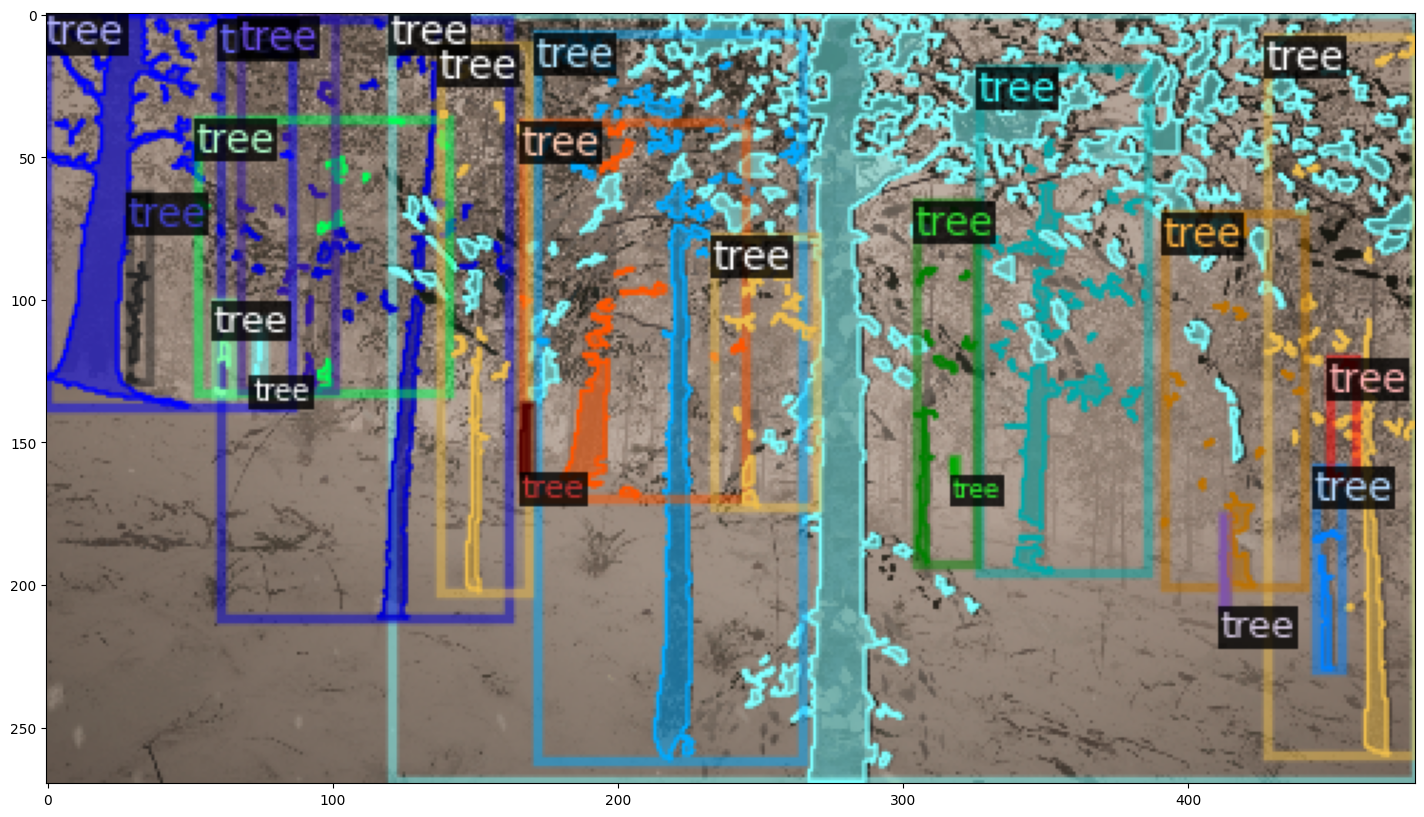

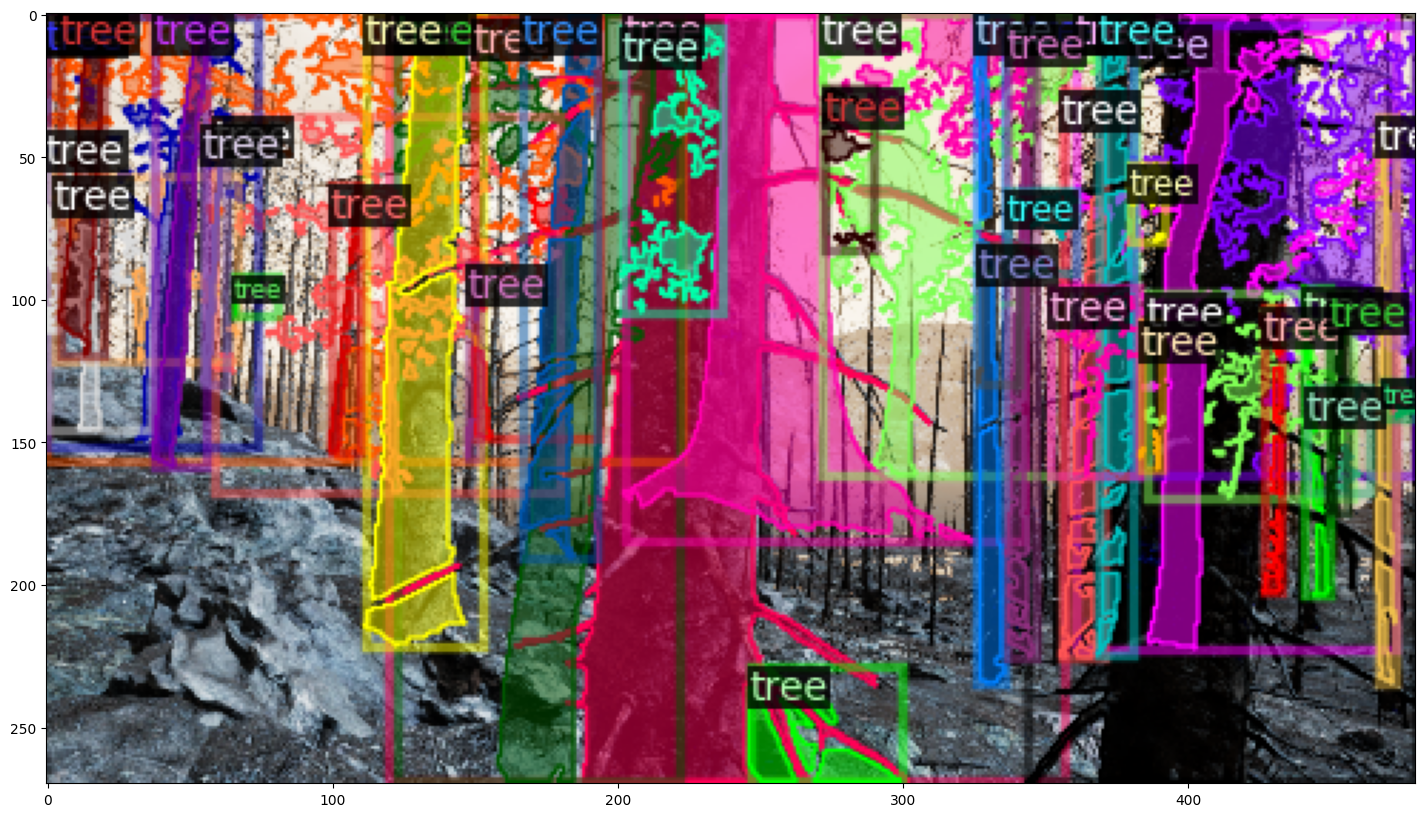

In [15]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show(18,10)

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [16]:
from detectron2.engine import DefaultTrainer

model_name = 'mask_rcnn_X_101_32x8d_FPN_3x'

cfg = get_cfg()
cfg.OUTPUT_DIR      = "/mnt/raid1/repos/maskdino/maskdino-output/" + model_name
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-InstanceSegmentation/{model_name}.yaml"))
cfg.DATASETS.TRAIN  = ("spread_train",)
cfg.DATASETS.TEST   = ("spread_valid")
cfg.DATALOADER.NUM_WORKERS = 32
cfg.MODEL.WEIGHTS   = model_zoo.get_checkpoint_url(f"COCO-InstanceSegmentation/{model_name}.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 32  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR  = 0.0005   # pick a good LR
cfg.SOLVER.MAX_ITER = 20000    # 1000 iterations = 1.5 hours on RTX A6000
cfg.SOLVER.STEPS    = []       # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

cfg.SOLVER.CHECKPOINT_PERIOD    = 500
cfg.SOLVER.REFERENCE_WORLD_SIZE = 2 # for dataparallel hopefully (nope, it doesn't work)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[01/14 19:37:52 d2.engine.defaults]: Auto-scaling the config to batch_size=16, learning_rate=0.00025, max_iter=40000, warmup=2000.
[01/14 19:37:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), str

[01/14 19:38:10 d2.data.datasets.coco]: Loading /mnt/raid1/dataset/spread/spread-v2/train.json takes 17.42 seconds.
[01/14 19:38:10 d2.data.datasets.coco]: Loaded 8356 images in COCO format from /mnt/raid1/dataset/spread/spread-v2/train.json
[01/14 19:38:11 d2.data.build]: Removed 0 images with no usable annotations. 8356 images left.
[01/14 19:38:11 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    tree    | 291274       |
|            |              |
[01/14 19:38:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/14 19:38:11 d2.data.build]: Using training sampler TrainingSampler
[01/14 19:38:11 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/14 19:38:11 d2.data.common]: Serializing 8356 elements t

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [17]:
_please_stop_here_with_an_error_

NameError: name '_please_stop_here_with_an_error_' is not defined

### Launch the training

In [ ]:
trainer.train() #Start the training process

[01/14 19:45:16 d2.engine.train_loop]: Starting training from iteration 0
[01/14 19:46:45 d2.utils.events]:  eta: 1 day, 21:17:30  iter: 19  total_loss: 7.791  loss_cls: 0.6083  loss_box_reg: 0.4353  loss_mask: 0.6902  loss_rpn_cls: 5.252  loss_rpn_loc: 0.7499    time: 4.0774  last_time: 4.1169  data_time: 0.4107  last_data_time: 0.0216   lr: 2.6226e-06  max_mem: 37639M
[01/14 19:48:08 d2.utils.events]:  eta: 1 day, 21:25:44  iter: 39  total_loss: 6.741  loss_cls: 0.6043  loss_box_reg: 0.5084  loss_mask: 0.6822  loss_rpn_cls: 4.231  loss_rpn_loc: 0.7114    time: 4.0924  last_time: 4.1837  data_time: 0.0285  last_data_time: 0.0304   lr: 5.1201e-06  max_mem: 37639M
[01/14 19:49:30 d2.utils.events]:  eta: 1 day, 21:30:45  iter: 59  total_loss: 5.162  loss_cls: 0.5944  loss_box_reg: 0.6303  loss_mask: 0.6689  loss_rpn_cls: 2.685  loss_rpn_loc: 0.6275    time: 4.1021  last_time: 4.1443  data_time: 0.0291  last_data_time: 0.0486   lr: 7.6176e-06  max_mem: 37639M
[01/14 19:50:52 d2.utils.even

[01/14 20:23:50 d2.utils.events]:  eta: 1 day, 21:06:01  iter: 559  total_loss: 2.362  loss_cls: 0.4643  loss_box_reg: 0.7746  loss_mask: 0.3914  loss_rpn_cls: 0.2689  loss_rpn_loc: 0.4792    time: 4.1172  last_time: 4.1513  data_time: 0.0307  last_data_time: 0.0337   lr: 7.0055e-05  max_mem: 37641M
[01/14 20:25:16 d2.utils.events]:  eta: 1 day, 21:05:24  iter: 579  total_loss: 2.392  loss_cls: 0.4618  loss_box_reg: 0.7713  loss_mask: 0.3836  loss_rpn_cls: 0.2825  loss_rpn_loc: 0.5016    time: 4.1227  last_time: 4.1318  data_time: 0.0310  last_data_time: 0.0311   lr: 7.2553e-05  max_mem: 37641M
[01/14 20:26:38 d2.utils.events]:  eta: 1 day, 21:04:01  iter: 599  total_loss: 2.384  loss_cls: 0.4636  loss_box_reg: 0.7902  loss_mask: 0.3886  loss_rpn_cls: 0.2527  loss_rpn_loc: 0.4967    time: 4.1228  last_time: 4.1266  data_time: 0.0317  last_data_time: 0.0320   lr: 7.505e-05  max_mem: 37641M
[01/14 20:28:01 d2.utils.events]:  eta: 1 day, 21:03:03  iter: 619  total_loss: 2.315  loss_cls: 0

[01/14 21:01:16 d2.utils.events]:  eta: 1 day, 20:34:40  iter: 1099  total_loss: 2.168  loss_cls: 0.419  loss_box_reg: 0.7286  loss_mask: 0.3306  loss_rpn_cls: 0.2289  loss_rpn_loc: 0.4506    time: 4.1294  last_time: 4.1433  data_time: 0.0301  last_data_time: 0.0527   lr: 0.00013749  max_mem: 37641M
[01/14 21:02:38 d2.utils.events]:  eta: 1 day, 20:33:31  iter: 1119  total_loss: 2.147  loss_cls: 0.4158  loss_box_reg: 0.7261  loss_mask: 0.3269  loss_rpn_cls: 0.2267  loss_rpn_loc: 0.4402    time: 4.1295  last_time: 4.1420  data_time: 0.0290  last_data_time: 0.0347   lr: 0.00013999  max_mem: 37641M
[01/14 21:04:01 d2.utils.events]:  eta: 1 day, 20:32:14  iter: 1139  total_loss: 2.178  loss_cls: 0.418  loss_box_reg: 0.7231  loss_mask: 0.3318  loss_rpn_cls: 0.2428  loss_rpn_loc: 0.4643    time: 4.1292  last_time: 4.1120  data_time: 0.0287  last_data_time: 0.0231   lr: 0.00014248  max_mem: 37641M
[01/14 21:05:23 d2.utils.events]:  eta: 1 day, 20:31:15  iter: 1159  total_loss: 2.138  loss_cls

[01/14 21:38:30 d2.utils.events]:  eta: 1 day, 20:00:19  iter: 1639  total_loss: 2.076  loss_cls: 0.4039  loss_box_reg: 0.6991  loss_mask: 0.3116  loss_rpn_cls: 0.2194  loss_rpn_loc: 0.4373    time: 4.1314  last_time: 4.1658  data_time: 0.0336  last_data_time: 0.0430   lr: 0.00020492  max_mem: 37641M
[01/14 21:39:52 d2.utils.events]:  eta: 1 day, 19:58:42  iter: 1659  total_loss: 2.04  loss_cls: 0.3997  loss_box_reg: 0.6926  loss_mask: 0.3218  loss_rpn_cls: 0.2167  loss_rpn_loc: 0.4439    time: 4.1313  last_time: 4.1134  data_time: 0.0290  last_data_time: 0.0303   lr: 0.00020742  max_mem: 37641M
[01/14 21:41:15 d2.utils.events]:  eta: 1 day, 19:57:20  iter: 1679  total_loss: 2.059  loss_cls: 0.398  loss_box_reg: 0.688  loss_mask: 0.3093  loss_rpn_cls: 0.2104  loss_rpn_loc: 0.4401    time: 4.1313  last_time: 4.1284  data_time: 0.0320  last_data_time: 0.0365   lr: 0.00020992  max_mem: 37641M
[01/14 21:42:37 d2.utils.events]:  eta: 1 day, 19:56:14  iter: 1699  total_loss: 2.066  loss_cls:

[01/14 22:15:50 d2.utils.events]:  eta: 1 day, 19:23:28  iter: 2179  total_loss: 2.05  loss_cls: 0.3955  loss_box_reg: 0.6755  loss_mask: 0.3063  loss_rpn_cls: 0.2259  loss_rpn_loc: 0.4378    time: 4.1322  last_time: 4.1156  data_time: 0.0297  last_data_time: 0.0174   lr: 0.00025  max_mem: 37641M
[01/14 22:17:13 d2.utils.events]:  eta: 1 day, 19:21:55  iter: 2199  total_loss: 2.037  loss_cls: 0.3949  loss_box_reg: 0.6754  loss_mask: 0.3071  loss_rpn_cls: 0.2189  loss_rpn_loc: 0.4473    time: 4.1321  last_time: 4.0684  data_time: 0.0303  last_data_time: 0.0116   lr: 0.00025  max_mem: 37641M
[01/14 22:18:35 d2.utils.events]:  eta: 1 day, 19:20:17  iter: 2219  total_loss: 2.009  loss_cls: 0.3837  loss_box_reg: 0.6771  loss_mask: 0.3009  loss_rpn_cls: 0.2031  loss_rpn_loc: 0.4348    time: 4.1321  last_time: 4.1224  data_time: 0.0299  last_data_time: 0.0268   lr: 0.00025  max_mem: 37641M
[01/14 22:19:58 d2.utils.events]:  eta: 1 day, 19:18:55  iter: 2239  total_loss: 2.002  loss_cls: 0.3854

[01/14 22:53:05 d2.utils.events]:  eta: 1 day, 18:46:21  iter: 2719  total_loss: 2.023  loss_cls: 0.3828  loss_box_reg: 0.6726  loss_mask: 0.3113  loss_rpn_cls: 0.1975  loss_rpn_loc: 0.4548    time: 4.1331  last_time: 4.1734  data_time: 0.0340  last_data_time: 0.0377   lr: 0.00025  max_mem: 37641M
[01/14 22:54:28 d2.utils.events]:  eta: 1 day, 18:45:17  iter: 2739  total_loss: 2.018  loss_cls: 0.3879  loss_box_reg: 0.673  loss_mask: 0.303  loss_rpn_cls: 0.2118  loss_rpn_loc: 0.4484    time: 4.1332  last_time: 4.1116  data_time: 0.0327  last_data_time: 0.0329   lr: 0.00025  max_mem: 37641M
[01/14 22:55:50 d2.utils.events]:  eta: 1 day, 18:43:52  iter: 2759  total_loss: 1.988  loss_cls: 0.3774  loss_box_reg: 0.6614  loss_mask: 0.293  loss_rpn_cls: 0.1995  loss_rpn_loc: 0.4253    time: 4.1331  last_time: 4.1445  data_time: 0.0300  last_data_time: 0.0464   lr: 0.00025  max_mem: 37641M
[01/14 22:57:13 d2.utils.events]:  eta: 1 day, 18:42:19  iter: 2779  total_loss: 2.04  loss_cls: 0.3901  l

[01/14 23:30:25 d2.utils.events]:  eta: 1 day, 18:08:17  iter: 3259  total_loss: 2.028  loss_cls: 0.385  loss_box_reg: 0.6856  loss_mask: 0.2942  loss_rpn_cls: 0.2017  loss_rpn_loc: 0.4371    time: 4.1331  last_time: 4.0975  data_time: 0.0285  last_data_time: 0.0276   lr: 0.00025  max_mem: 37641M
[01/14 23:31:48 d2.utils.events]:  eta: 1 day, 18:06:53  iter: 3279  total_loss: 1.967  loss_cls: 0.3784  loss_box_reg: 0.6672  loss_mask: 0.2913  loss_rpn_cls: 0.1991  loss_rpn_loc: 0.4298    time: 4.1331  last_time: 4.1309  data_time: 0.0279  last_data_time: 0.0394   lr: 0.00025  max_mem: 37641M
[01/14 23:33:10 d2.utils.events]:  eta: 1 day, 18:05:43  iter: 3299  total_loss: 1.95  loss_cls: 0.3799  loss_box_reg: 0.6561  loss_mask: 0.3022  loss_rpn_cls: 0.2054  loss_rpn_loc: 0.4246    time: 4.1331  last_time: 4.1467  data_time: 0.0292  last_data_time: 0.0458   lr: 0.00025  max_mem: 37641M
[01/14 23:34:33 d2.utils.events]:  eta: 1 day, 18:04:20  iter: 3319  total_loss: 1.968  loss_cls: 0.3746 

[01/15 00:07:37 d2.utils.events]:  eta: 1 day, 17:28:56  iter: 3799  total_loss: 1.978  loss_cls: 0.3682  loss_box_reg: 0.6563  loss_mask: 0.2929  loss_rpn_cls: 0.1977  loss_rpn_loc: 0.4178    time: 4.1329  last_time: 4.1486  data_time: 0.0301  last_data_time: 0.0416   lr: 0.00025  max_mem: 37641M
[01/15 00:09:00 d2.utils.events]:  eta: 1 day, 17:27:22  iter: 3819  total_loss: 1.954  loss_cls: 0.3649  loss_box_reg: 0.6454  loss_mask: 0.2983  loss_rpn_cls: 0.204  loss_rpn_loc: 0.4235    time: 4.1328  last_time: 4.1747  data_time: 0.0306  last_data_time: 0.0566   lr: 0.00025  max_mem: 37641M
[01/15 00:10:22 d2.utils.events]:  eta: 1 day, 17:25:42  iter: 3839  total_loss: 1.919  loss_cls: 0.3707  loss_box_reg: 0.6446  loss_mask: 0.2947  loss_rpn_cls: 0.1947  loss_rpn_loc: 0.4255    time: 4.1328  last_time: 4.1251  data_time: 0.0309  last_data_time: 0.0430   lr: 0.00025  max_mem: 37641M
[01/15 00:11:44 d2.utils.events]:  eta: 1 day, 17:24:09  iter: 3859  total_loss: 1.915  loss_cls: 0.3691

[01/15 00:44:56 d2.utils.events]:  eta: 1 day, 16:51:13  iter: 4339  total_loss: 1.926  loss_cls: 0.3613  loss_box_reg: 0.6494  loss_mask: 0.2957  loss_rpn_cls: 0.1926  loss_rpn_loc: 0.4118    time: 4.1326  last_time: 4.0992  data_time: 0.0322  last_data_time: 0.0117   lr: 0.00025  max_mem: 37641M
[01/15 00:46:19 d2.utils.events]:  eta: 1 day, 16:50:23  iter: 4359  total_loss: 1.921  loss_cls: 0.3665  loss_box_reg: 0.665  loss_mask: 0.2894  loss_rpn_cls: 0.1954  loss_rpn_loc: 0.3972    time: 4.1327  last_time: 4.1564  data_time: 0.0302  last_data_time: 0.0169   lr: 0.00025  max_mem: 37641M
[01/15 00:47:42 d2.utils.events]:  eta: 1 day, 16:49:20  iter: 4379  total_loss: 1.919  loss_cls: 0.3698  loss_box_reg: 0.6545  loss_mask: 0.299  loss_rpn_cls: 0.2  loss_rpn_loc: 0.4131    time: 4.1326  last_time: 4.1009  data_time: 0.0294  last_data_time: 0.0291   lr: 0.00025  max_mem: 37641M
[01/15 00:49:04 d2.utils.events]:  eta: 1 day, 16:47:58  iter: 4399  total_loss: 1.93  loss_cls: 0.3737  los

[01/15 01:22:08 d2.utils.events]:  eta: 1 day, 16:15:06  iter: 4879  total_loss: 1.881  loss_cls: 0.3585  loss_box_reg: 0.644  loss_mask: 0.2863  loss_rpn_cls: 0.1895  loss_rpn_loc: 0.4106    time: 4.1324  last_time: 4.0915  data_time: 0.0290  last_data_time: 0.0430   lr: 0.00025  max_mem: 37641M
[01/15 01:23:30 d2.utils.events]:  eta: 1 day, 16:13:37  iter: 4899  total_loss: 1.914  loss_cls: 0.3676  loss_box_reg: 0.6534  loss_mask: 0.282  loss_rpn_cls: 0.1894  loss_rpn_loc: 0.4189    time: 4.1323  last_time: 4.1466  data_time: 0.0313  last_data_time: 0.0098   lr: 0.00025  max_mem: 37641M
[01/15 01:24:53 d2.utils.events]:  eta: 1 day, 16:12:27  iter: 4919  total_loss: 1.956  loss_cls: 0.3604  loss_box_reg: 0.6389  loss_mask: 0.2899  loss_rpn_cls: 0.1926  loss_rpn_loc: 0.4353    time: 4.1324  last_time: 4.1695  data_time: 0.0300  last_data_time: 0.0273   lr: 0.00025  max_mem: 37641M
[01/15 01:26:16 d2.utils.events]:  eta: 1 day, 16:11:10  iter: 4939  total_loss: 1.93  loss_cls: 0.3658  

[01/15 01:59:26 d2.utils.events]:  eta: 1 day, 15:37:23  iter: 5419  total_loss: 1.911  loss_cls: 0.3616  loss_box_reg: 0.6517  loss_mask: 0.2899  loss_rpn_cls: 0.1988  loss_rpn_loc: 0.4118    time: 4.1322  last_time: 4.1354  data_time: 0.0311  last_data_time: 0.0226   lr: 0.00025  max_mem: 37641M
[01/15 02:00:49 d2.utils.events]:  eta: 1 day, 15:35:58  iter: 5439  total_loss: 1.927  loss_cls: 0.3647  loss_box_reg: 0.6428  loss_mask: 0.2939  loss_rpn_cls: 0.1934  loss_rpn_loc: 0.4305    time: 4.1321  last_time: 4.1197  data_time: 0.0294  last_data_time: 0.0269   lr: 0.00025  max_mem: 37641M
[01/15 02:02:11 d2.utils.events]:  eta: 1 day, 15:34:30  iter: 5459  total_loss: 1.921  loss_cls: 0.3637  loss_box_reg: 0.6595  loss_mask: 0.2896  loss_rpn_cls: 0.1975  loss_rpn_loc: 0.4279    time: 4.1321  last_time: 4.1011  data_time: 0.0306  last_data_time: 0.0102   lr: 0.00025  max_mem: 37641M
[01/15 02:03:34 d2.utils.events]:  eta: 1 day, 15:33:05  iter: 5479  total_loss: 1.91  loss_cls: 0.3709

[01/15 02:36:38 d2.utils.events]:  eta: 1 day, 15:00:24  iter: 5959  total_loss: 1.938  loss_cls: 0.3666  loss_box_reg: 0.6558  loss_mask: 0.2949  loss_rpn_cls: 0.1898  loss_rpn_loc: 0.4027    time: 4.1321  last_time: 4.1389  data_time: 0.0301  last_data_time: 0.0525   lr: 0.00025  max_mem: 37641M
[01/15 02:38:01 d2.utils.events]:  eta: 1 day, 14:59:18  iter: 5979  total_loss: 1.95  loss_cls: 0.3619  loss_box_reg: 0.6561  loss_mask: 0.2928  loss_rpn_cls: 0.1936  loss_rpn_loc: 0.4319    time: 4.1322  last_time: 4.1214  data_time: 0.0304  last_data_time: 0.0289   lr: 0.00025  max_mem: 37641M
[01/15 02:39:31 d2.utils.events]:  eta: 1 day, 14:57:56  iter: 5999  total_loss: 1.901  loss_cls: 0.3627  loss_box_reg: 0.6378  loss_mask: 0.2948  loss_rpn_cls: 0.1869  loss_rpn_loc: 0.4138    time: 4.1321  last_time: 4.1108  data_time: 0.0296  last_data_time: 0.0238   lr: 0.00025  max_mem: 37641M
[01/15 02:40:53 d2.utils.events]:  eta: 1 day, 14:56:29  iter: 6019  total_loss: 1.903  loss_cls: 0.3636

[01/15 03:13:57 d2.utils.events]:  eta: 1 day, 14:22:25  iter: 6499  total_loss: 1.898  loss_cls: 0.3585  loss_box_reg: 0.6406  loss_mask: 0.2907  loss_rpn_cls: 0.1946  loss_rpn_loc: 0.4243    time: 4.1319  last_time: 4.1562  data_time: 0.0277  last_data_time: 0.0217   lr: 0.00025  max_mem: 37641M
[01/15 03:15:22 d2.utils.events]:  eta: 1 day, 14:20:34  iter: 6519  total_loss: 1.905  loss_cls: 0.3642  loss_box_reg: 0.6527  loss_mask: 0.2793  loss_rpn_cls: 0.1888  loss_rpn_loc: 0.4034    time: 4.1323  last_time: 4.1083  data_time: 0.0289  last_data_time: 0.0294   lr: 0.00025  max_mem: 37641M
[01/15 03:16:44 d2.utils.events]:  eta: 1 day, 14:19:05  iter: 6539  total_loss: 1.831  loss_cls: 0.3485  loss_box_reg: 0.6304  loss_mask: 0.2811  loss_rpn_cls: 0.1805  loss_rpn_loc: 0.3976    time: 4.1323  last_time: 4.0918  data_time: 0.0302  last_data_time: 0.0443   lr: 0.00025  max_mem: 37641M
[01/15 03:18:07 d2.utils.events]:  eta: 1 day, 14:17:41  iter: 6559  total_loss: 1.88  loss_cls: 0.3536

[01/15 03:51:17 d2.utils.events]:  eta: 1 day, 13:44:09  iter: 7039  total_loss: 1.858  loss_cls: 0.3508  loss_box_reg: 0.6426  loss_mask: 0.2933  loss_rpn_cls: 0.182  loss_rpn_loc: 0.4105    time: 4.1320  last_time: 4.0911  data_time: 0.0291  last_data_time: 0.0207   lr: 0.00025  max_mem: 37641M
[01/15 03:52:39 d2.utils.events]:  eta: 1 day, 13:42:43  iter: 7059  total_loss: 1.818  loss_cls: 0.3434  loss_box_reg: 0.6207  loss_mask: 0.2818  loss_rpn_cls: 0.1965  loss_rpn_loc: 0.4031    time: 4.1319  last_time: 4.1291  data_time: 0.0300  last_data_time: 0.0304   lr: 0.00025  max_mem: 37641M
[01/15 03:54:02 d2.utils.events]:  eta: 1 day, 13:41:19  iter: 7079  total_loss: 1.902  loss_cls: 0.3607  loss_box_reg: 0.6591  loss_mask: 0.2939  loss_rpn_cls: 0.1871  loss_rpn_loc: 0.414    time: 4.1319  last_time: 4.1640  data_time: 0.0293  last_data_time: 0.0346   lr: 0.00025  max_mem: 37641M
[01/15 03:55:24 d2.utils.events]:  eta: 1 day, 13:39:57  iter: 7099  total_loss: 1.857  loss_cls: 0.3553 

[01/15 04:28:26 d2.utils.events]:  eta: 1 day, 13:07:12  iter: 7579  total_loss: 1.8  loss_cls: 0.3431  loss_box_reg: 0.6131  loss_mask: 0.2831  loss_rpn_cls: 0.1762  loss_rpn_loc: 0.3852    time: 4.1316  last_time: 4.0799  data_time: 0.0299  last_data_time: 0.0126   lr: 0.00025  max_mem: 37641M
[01/15 04:29:49 d2.utils.events]:  eta: 1 day, 13:05:50  iter: 7599  total_loss: 1.894  loss_cls: 0.3602  loss_box_reg: 0.6291  loss_mask: 0.2888  loss_rpn_cls: 0.1934  loss_rpn_loc: 0.4046    time: 4.1316  last_time: 4.0856  data_time: 0.0290  last_data_time: 0.0193   lr: 0.00025  max_mem: 37641M
[01/15 04:31:11 d2.utils.events]:  eta: 1 day, 13:04:21  iter: 7619  total_loss: 1.912  loss_cls: 0.358  loss_box_reg: 0.6359  loss_mask: 0.2935  loss_rpn_cls: 0.1784  loss_rpn_loc: 0.4059    time: 4.1315  last_time: 4.1006  data_time: 0.0289  last_data_time: 0.0123   lr: 0.00025  max_mem: 37641M
[01/15 04:32:34 d2.utils.events]:  eta: 1 day, 13:03:05  iter: 7639  total_loss: 1.934  loss_cls: 0.3662  

[01/15 05:05:47 d2.utils.events]:  eta: 1 day, 12:29:44  iter: 8119  total_loss: 1.857  loss_cls: 0.3482  loss_box_reg: 0.6285  loss_mask: 0.2907  loss_rpn_cls: 0.1927  loss_rpn_loc: 0.3985    time: 4.1318  last_time: 4.1236  data_time: 0.0293  last_data_time: 0.0373   lr: 0.00025  max_mem: 37641M
[01/15 05:07:10 d2.utils.events]:  eta: 1 day, 12:28:18  iter: 8139  total_loss: 1.92  loss_cls: 0.3554  loss_box_reg: 0.6473  loss_mask: 0.2887  loss_rpn_cls: 0.1935  loss_rpn_loc: 0.4354    time: 4.1318  last_time: 4.0868  data_time: 0.0289  last_data_time: 0.0396   lr: 0.00025  max_mem: 37641M
[01/15 05:08:32 d2.utils.events]:  eta: 1 day, 12:26:56  iter: 8159  total_loss: 1.851  loss_cls: 0.3565  loss_box_reg: 0.6337  loss_mask: 0.2885  loss_rpn_cls: 0.1921  loss_rpn_loc: 0.4064    time: 4.1318  last_time: 4.1893  data_time: 0.0294  last_data_time: 0.0481   lr: 0.00025  max_mem: 37641M
[01/15 05:09:55 d2.utils.events]:  eta: 1 day, 12:25:37  iter: 8179  total_loss: 1.922  loss_cls: 0.3552

[01/15 05:42:57 d2.utils.events]:  eta: 1 day, 11:52:42  iter: 8659  total_loss: 1.887  loss_cls: 0.3644  loss_box_reg: 0.6595  loss_mask: 0.2877  loss_rpn_cls: 0.1904  loss_rpn_loc: 0.4045    time: 4.1315  last_time: 4.0943  data_time: 0.0309  last_data_time: 0.0378   lr: 0.00025  max_mem: 37641M
[01/15 05:44:19 d2.utils.events]:  eta: 1 day, 11:51:19  iter: 8679  total_loss: 1.896  loss_cls: 0.3562  loss_box_reg: 0.6413  loss_mask: 0.2892  loss_rpn_cls: 0.1834  loss_rpn_loc: 0.3961    time: 4.1315  last_time: 4.1590  data_time: 0.0297  last_data_time: 0.0337   lr: 0.00025  max_mem: 37641M
[01/15 05:45:41 d2.utils.events]:  eta: 1 day, 11:49:50  iter: 8699  total_loss: 1.901  loss_cls: 0.3579  loss_box_reg: 0.6383  loss_mask: 0.2979  loss_rpn_cls: 0.1913  loss_rpn_loc: 0.4051    time: 4.1314  last_time: 4.0880  data_time: 0.0290  last_data_time: 0.0095   lr: 0.00025  max_mem: 37641M
[01/15 05:47:04 d2.utils.events]:  eta: 1 day, 11:48:08  iter: 8719  total_loss: 1.891  loss_cls: 0.353

[01/15 06:20:13 d2.utils.events]:  eta: 1 day, 11:15:36  iter: 9199  total_loss: 1.886  loss_cls: 0.3534  loss_box_reg: 0.6331  loss_mask: 0.2891  loss_rpn_cls: 0.1927  loss_rpn_loc: 0.4148    time: 4.1312  last_time: 4.1538  data_time: 0.0330  last_data_time: 0.0534   lr: 0.00025  max_mem: 37641M
[01/15 06:21:36 d2.utils.events]:  eta: 1 day, 11:14:33  iter: 9219  total_loss: 1.886  loss_cls: 0.3584  loss_box_reg: 0.6361  loss_mask: 0.2875  loss_rpn_cls: 0.1865  loss_rpn_loc: 0.4196    time: 4.1312  last_time: 4.1161  data_time: 0.0296  last_data_time: 0.0174   lr: 0.00025  max_mem: 37641M
[01/15 06:22:59 d2.utils.events]:  eta: 1 day, 11:13:20  iter: 9239  total_loss: 1.827  loss_cls: 0.346  loss_box_reg: 0.6396  loss_mask: 0.2826  loss_rpn_cls: 0.1833  loss_rpn_loc: 0.3933    time: 4.1312  last_time: 4.1371  data_time: 0.0328  last_data_time: 0.0258   lr: 0.00025  max_mem: 37641M
[01/15 06:24:21 d2.utils.events]:  eta: 1 day, 11:11:59  iter: 9259  total_loss: 1.88  loss_cls: 0.3501 

[01/15 06:57:23 d2.utils.events]:  eta: 1 day, 10:38:34  iter: 9739  total_loss: 1.791  loss_cls: 0.3394  loss_box_reg: 0.6195  loss_mask: 0.2821  loss_rpn_cls: 0.1688  loss_rpn_loc: 0.3917    time: 4.1309  last_time: 4.0926  data_time: 0.0285  last_data_time: 0.0239   lr: 0.00025  max_mem: 37641M
[01/15 06:58:45 d2.utils.events]:  eta: 1 day, 10:37:00  iter: 9759  total_loss: 1.893  loss_cls: 0.3484  loss_box_reg: 0.6282  loss_mask: 0.2944  loss_rpn_cls: 0.1924  loss_rpn_loc: 0.41    time: 4.1309  last_time: 4.0959  data_time: 0.0300  last_data_time: 0.0318   lr: 0.00025  max_mem: 37641M
[01/15 07:00:08 d2.utils.events]:  eta: 1 day, 10:35:56  iter: 9779  total_loss: 1.902  loss_cls: 0.3586  loss_box_reg: 0.6434  loss_mask: 0.2974  loss_rpn_cls: 0.1885  loss_rpn_loc: 0.4143    time: 4.1309  last_time: 4.1829  data_time: 0.0328  last_data_time: 0.0430   lr: 0.00025  max_mem: 37641M
[01/15 07:01:30 d2.utils.events]:  eta: 1 day, 10:34:45  iter: 9799  total_loss: 1.857  loss_cls: 0.3477 

[01/15 07:34:39 d2.utils.events]:  eta: 1 day, 10:01:06  iter: 10279  total_loss: 1.849  loss_cls: 0.3583  loss_box_reg: 0.622  loss_mask: 0.2858  loss_rpn_cls: 0.1867  loss_rpn_loc: 0.4176    time: 4.1306  last_time: 4.1293  data_time: 0.0326  last_data_time: 0.0571   lr: 0.00025  max_mem: 37641M
[01/15 07:36:01 d2.utils.events]:  eta: 1 day, 9:59:49  iter: 10299  total_loss: 1.853  loss_cls: 0.3492  loss_box_reg: 0.6316  loss_mask: 0.2847  loss_rpn_cls: 0.175  loss_rpn_loc: 0.3994    time: 4.1306  last_time: 4.1380  data_time: 0.0289  last_data_time: 0.0442   lr: 0.00025  max_mem: 37641M
[01/15 07:37:24 d2.utils.events]:  eta: 1 day, 9:58:27  iter: 10319  total_loss: 1.919  loss_cls: 0.3525  loss_box_reg: 0.6456  loss_mask: 0.2845  loss_rpn_cls: 0.1858  loss_rpn_loc: 0.4175    time: 4.1306  last_time: 4.1103  data_time: 0.0331  last_data_time: 0.0323   lr: 0.00025  max_mem: 37641M
[01/15 07:38:46 d2.utils.events]:  eta: 1 day, 9:56:55  iter: 10339  total_loss: 1.867  loss_cls: 0.3493

[01/15 08:11:47 d2.utils.events]:  eta: 1 day, 9:23:20  iter: 10819  total_loss: 1.832  loss_cls: 0.3512  loss_box_reg: 0.6167  loss_mask: 0.2799  loss_rpn_cls: 0.1834  loss_rpn_loc: 0.418    time: 4.1303  last_time: 4.1211  data_time: 0.0319  last_data_time: 0.0410   lr: 0.00025  max_mem: 37641M
[01/15 08:13:10 d2.utils.events]:  eta: 1 day, 9:22:21  iter: 10839  total_loss: 1.819  loss_cls: 0.3441  loss_box_reg: 0.626  loss_mask: 0.2853  loss_rpn_cls: 0.1822  loss_rpn_loc: 0.404    time: 4.1303  last_time: 4.1981  data_time: 0.0280  last_data_time: 0.0248   lr: 0.00025  max_mem: 37641M
[01/15 08:14:32 d2.utils.events]:  eta: 1 day, 9:20:59  iter: 10859  total_loss: 1.859  loss_cls: 0.3472  loss_box_reg: 0.6261  loss_mask: 0.2885  loss_rpn_cls: 0.19  loss_rpn_loc: 0.4032    time: 4.1303  last_time: 4.1155  data_time: 0.0299  last_data_time: 0.0151   lr: 0.00025  max_mem: 37641M
[01/15 08:15:54 d2.utils.events]:  eta: 1 day, 9:19:37  iter: 10879  total_loss: 1.806  loss_cls: 0.3375  lo

[01/15 08:49:03 d2.utils.events]:  eta: 1 day, 8:46:28  iter: 11359  total_loss: 1.842  loss_cls: 0.342  loss_box_reg: 0.628  loss_mask: 0.285  loss_rpn_cls: 0.1802  loss_rpn_loc: 0.3979    time: 4.1301  last_time: 4.1339  data_time: 0.0324  last_data_time: 0.0303   lr: 0.00025  max_mem: 37641M
[01/15 08:50:26 d2.utils.events]:  eta: 1 day, 8:45:09  iter: 11379  total_loss: 1.865  loss_cls: 0.3484  loss_box_reg: 0.6229  loss_mask: 0.2829  loss_rpn_cls: 0.1857  loss_rpn_loc: 0.4124    time: 4.1301  last_time: 4.1239  data_time: 0.0319  last_data_time: 0.0192   lr: 0.00025  max_mem: 37641M
[01/15 08:51:48 d2.utils.events]:  eta: 1 day, 8:43:41  iter: 11399  total_loss: 1.831  loss_cls: 0.3369  loss_box_reg: 0.6235  loss_mask: 0.2825  loss_rpn_cls: 0.1881  loss_rpn_loc: 0.3953    time: 4.1300  last_time: 4.1118  data_time: 0.0284  last_data_time: 0.0422   lr: 0.00025  max_mem: 37641M
[01/15 08:53:10 d2.utils.events]:  eta: 1 day, 8:42:25  iter: 11419  total_loss: 1.924  loss_cls: 0.352  l

[01/15 09:26:12 d2.utils.events]:  eta: 1 day, 8:09:36  iter: 11899  total_loss: 1.813  loss_cls: 0.3429  loss_box_reg: 0.6289  loss_mask: 0.2792  loss_rpn_cls: 0.1729  loss_rpn_loc: 0.3882    time: 4.1299  last_time: 4.1407  data_time: 0.0279  last_data_time: 0.0269   lr: 0.00025  max_mem: 37641M
[01/15 09:27:34 d2.utils.events]:  eta: 1 day, 8:08:24  iter: 11919  total_loss: 1.851  loss_cls: 0.353  loss_box_reg: 0.6293  loss_mask: 0.2828  loss_rpn_cls: 0.1872  loss_rpn_loc: 0.4087    time: 4.1298  last_time: 4.1024  data_time: 0.0308  last_data_time: 0.0131   lr: 0.00025  max_mem: 37641M
[01/15 09:28:56 d2.utils.events]:  eta: 1 day, 8:07:01  iter: 11939  total_loss: 1.854  loss_cls: 0.3426  loss_box_reg: 0.629  loss_mask: 0.2801  loss_rpn_cls: 0.1853  loss_rpn_loc: 0.4091    time: 4.1298  last_time: 4.1221  data_time: 0.0331  last_data_time: 0.0112   lr: 0.00025  max_mem: 37641M
[01/15 09:30:19 d2.utils.events]:  eta: 1 day, 8:05:38  iter: 11959  total_loss: 1.791  loss_cls: 0.3379 

[01/15 10:03:29 d2.utils.events]:  eta: 1 day, 7:32:22  iter: 12439  total_loss: 1.872  loss_cls: 0.3464  loss_box_reg: 0.6267  loss_mask: 0.2807  loss_rpn_cls: 0.1896  loss_rpn_loc: 0.4076    time: 4.1297  last_time: 4.1249  data_time: 0.0281  last_data_time: 0.0226   lr: 0.00025  max_mem: 37642M
[01/15 10:04:52 d2.utils.events]:  eta: 1 day, 7:31:17  iter: 12459  total_loss: 1.861  loss_cls: 0.3428  loss_box_reg: 0.627  loss_mask: 0.278  loss_rpn_cls: 0.184  loss_rpn_loc: 0.4002    time: 4.1297  last_time: 4.1343  data_time: 0.0293  last_data_time: 0.0116   lr: 0.00025  max_mem: 37642M
[01/15 10:06:14 d2.utils.events]:  eta: 1 day, 7:29:58  iter: 12479  total_loss: 1.824  loss_cls: 0.3503  loss_box_reg: 0.6346  loss_mask: 0.2812  loss_rpn_cls: 0.1822  loss_rpn_loc: 0.4061    time: 4.1297  last_time: 4.1181  data_time: 0.0284  last_data_time: 0.0100   lr: 0.00025  max_mem: 37642M
[01/15 10:07:40 d2.utils.events]:  eta: 1 day, 7:28:39  iter: 12499  total_loss: 1.824  loss_cls: 0.3443  

[01/15 10:40:40 d2.utils.events]:  eta: 1 day, 6:56:21  iter: 12979  total_loss: 1.871  loss_cls: 0.3468  loss_box_reg: 0.6178  loss_mask: 0.2856  loss_rpn_cls: 0.1893  loss_rpn_loc: 0.4053    time: 4.1297  last_time: 4.0823  data_time: 0.0321  last_data_time: 0.0340   lr: 0.00025  max_mem: 37642M
[01/15 10:42:13 d2.utils.events]:  eta: 1 day, 6:54:46  iter: 12999  total_loss: 1.822  loss_cls: 0.345  loss_box_reg: 0.6121  loss_mask: 0.2833  loss_rpn_cls: 0.1851  loss_rpn_loc: 0.3951    time: 4.1299  last_time: 4.1303  data_time: 0.0303  last_data_time: 0.0335   lr: 0.00025  max_mem: 37642M
[01/15 10:43:37 d2.utils.events]:  eta: 1 day, 6:53:20  iter: 13019  total_loss: 1.861  loss_cls: 0.3455  loss_box_reg: 0.6234  loss_mask: 0.289  loss_rpn_cls: 0.1917  loss_rpn_loc: 0.4071    time: 4.1299  last_time: 4.1452  data_time: 0.0305  last_data_time: 0.0136   lr: 0.00025  max_mem: 37642M
[01/15 10:45:00 d2.utils.events]:  eta: 1 day, 6:52:11  iter: 13039  total_loss: 1.836  loss_cls: 0.3395 

[01/15 11:18:05 d2.utils.events]:  eta: 1 day, 6:20:34  iter: 13519  total_loss: 1.838  loss_cls: 0.3389  loss_box_reg: 0.6228  loss_mask: 0.2875  loss_rpn_cls: 0.1851  loss_rpn_loc: 0.406    time: 4.1300  last_time: 4.1486  data_time: 0.0281  last_data_time: 0.0273   lr: 0.00025  max_mem: 37642M
[01/15 11:19:28 d2.utils.events]:  eta: 1 day, 6:19:08  iter: 13539  total_loss: 1.75  loss_cls: 0.3371  loss_box_reg: 0.5989  loss_mask: 0.2758  loss_rpn_cls: 0.1697  loss_rpn_loc: 0.3833    time: 4.1300  last_time: 4.1165  data_time: 0.0278  last_data_time: 0.0470   lr: 0.00025  max_mem: 37642M
[01/15 11:20:50 d2.utils.events]:  eta: 1 day, 6:17:45  iter: 13559  total_loss: 1.833  loss_cls: 0.3421  loss_box_reg: 0.6181  loss_mask: 0.2765  loss_rpn_cls: 0.1848  loss_rpn_loc: 0.3881    time: 4.1300  last_time: 4.0957  data_time: 0.0303  last_data_time: 0.0302   lr: 0.00025  max_mem: 37642M
[01/15 11:22:13 d2.utils.events]:  eta: 1 day, 6:16:11  iter: 13579  total_loss: 1.871  loss_cls: 0.3444 

[01/15 11:55:18 d2.utils.events]:  eta: 1 day, 5:43:53  iter: 14059  total_loss: 1.851  loss_cls: 0.3388  loss_box_reg: 0.6173  loss_mask: 0.2933  loss_rpn_cls: 0.1843  loss_rpn_loc: 0.4026    time: 4.1301  last_time: 4.0883  data_time: 0.0289  last_data_time: 0.0099   lr: 0.00025  max_mem: 37642M
[01/15 11:56:41 d2.utils.events]:  eta: 1 day, 5:42:39  iter: 14079  total_loss: 1.882  loss_cls: 0.3502  loss_box_reg: 0.6361  loss_mask: 0.285  loss_rpn_cls: 0.1912  loss_rpn_loc: 0.4262    time: 4.1301  last_time: 4.1227  data_time: 0.0323  last_data_time: 0.0258   lr: 0.00025  max_mem: 37642M
[01/15 11:58:04 d2.utils.events]:  eta: 1 day, 5:41:26  iter: 14099  total_loss: 1.808  loss_cls: 0.3367  loss_box_reg: 0.6147  loss_mask: 0.2795  loss_rpn_cls: 0.175  loss_rpn_loc: 0.4074    time: 4.1301  last_time: 4.1224  data_time: 0.0336  last_data_time: 0.0247   lr: 0.00025  max_mem: 37642M
[01/15 11:59:27 d2.utils.events]:  eta: 1 day, 5:40:06  iter: 14119  total_loss: 1.83  loss_cls: 0.3398  

[01/15 12:32:35 d2.utils.events]:  eta: 1 day, 5:07:15  iter: 14599  total_loss: 1.878  loss_cls: 0.3483  loss_box_reg: 0.6311  loss_mask: 0.2864  loss_rpn_cls: 0.1955  loss_rpn_loc: 0.4276    time: 4.1303  last_time: 4.1221  data_time: 0.0330  last_data_time: 0.0100   lr: 0.00025  max_mem: 37642M
[01/15 12:33:58 d2.utils.events]:  eta: 1 day, 5:05:43  iter: 14619  total_loss: 1.795  loss_cls: 0.3404  loss_box_reg: 0.6124  loss_mask: 0.2851  loss_rpn_cls: 0.1831  loss_rpn_loc: 0.398    time: 4.1303  last_time: 4.1422  data_time: 0.0292  last_data_time: 0.0282   lr: 0.00025  max_mem: 37642M
[01/15 12:35:20 d2.utils.events]:  eta: 1 day, 5:04:21  iter: 14639  total_loss: 1.867  loss_cls: 0.3503  loss_box_reg: 0.6331  loss_mask: 0.2942  loss_rpn_cls: 0.1834  loss_rpn_loc: 0.4143    time: 4.1303  last_time: 4.1222  data_time: 0.0311  last_data_time: 0.0202   lr: 0.00025  max_mem: 37642M
[01/15 12:36:43 d2.utils.events]:  eta: 1 day, 5:03:06  iter: 14659  total_loss: 1.831  loss_cls: 0.3353

[01/15 13:09:48 d2.utils.events]:  eta: 1 day, 4:29:44  iter: 15139  total_loss: 1.851  loss_cls: 0.3455  loss_box_reg: 0.6178  loss_mask: 0.2825  loss_rpn_cls: 0.187  loss_rpn_loc: 0.4056    time: 4.1304  last_time: 4.1122  data_time: 0.0294  last_data_time: 0.0273   lr: 0.00025  max_mem: 37642M
[01/15 13:11:11 d2.utils.events]:  eta: 1 day, 4:28:25  iter: 15159  total_loss: 1.833  loss_cls: 0.3421  loss_box_reg: 0.6268  loss_mask: 0.2762  loss_rpn_cls: 0.1853  loss_rpn_loc: 0.3927    time: 4.1303  last_time: 4.1352  data_time: 0.0297  last_data_time: 0.0305   lr: 0.00025  max_mem: 37642M
[01/15 13:12:33 d2.utils.events]:  eta: 1 day, 4:26:54  iter: 15179  total_loss: 1.823  loss_cls: 0.344  loss_box_reg: 0.619  loss_mask: 0.2844  loss_rpn_cls: 0.1803  loss_rpn_loc: 0.3877    time: 4.1303  last_time: 4.1244  data_time: 0.0297  last_data_time: 0.0237   lr: 0.00025  max_mem: 37642M
[01/15 13:13:56 d2.utils.events]:  eta: 1 day, 4:25:27  iter: 15199  total_loss: 1.772  loss_cls: 0.3361  

[01/15 13:47:03 d2.utils.events]:  eta: 1 day, 3:52:14  iter: 15679  total_loss: 1.887  loss_cls: 0.3463  loss_box_reg: 0.6243  loss_mask: 0.2829  loss_rpn_cls: 0.198  loss_rpn_loc: 0.4036    time: 4.1305  last_time: 4.1158  data_time: 0.0296  last_data_time: 0.0333   lr: 0.00025  max_mem: 37642M
[01/15 13:48:25 d2.utils.events]:  eta: 1 day, 3:50:52  iter: 15699  total_loss: 1.835  loss_cls: 0.3519  loss_box_reg: 0.6166  loss_mask: 0.2832  loss_rpn_cls: 0.1797  loss_rpn_loc: 0.3949    time: 4.1305  last_time: 4.1557  data_time: 0.0300  last_data_time: 0.0403   lr: 0.00025  max_mem: 37642M
[01/15 13:49:48 d2.utils.events]:  eta: 1 day, 3:49:54  iter: 15719  total_loss: 1.824  loss_cls: 0.3318  loss_box_reg: 0.6158  loss_mask: 0.2898  loss_rpn_cls: 0.1773  loss_rpn_loc: 0.4194    time: 4.1305  last_time: 4.1331  data_time: 0.0331  last_data_time: 0.0159   lr: 0.00025  max_mem: 37642M
[01/15 13:51:11 d2.utils.events]:  eta: 1 day, 3:48:22  iter: 15739  total_loss: 1.821  loss_cls: 0.338 

[01/15 14:24:17 d2.utils.events]:  eta: 1 day, 3:15:42  iter: 16219  total_loss: 1.846  loss_cls: 0.3356  loss_box_reg: 0.6136  loss_mask: 0.2764  loss_rpn_cls: 0.1875  loss_rpn_loc: 0.4129    time: 4.1306  last_time: 4.1310  data_time: 0.0289  last_data_time: 0.0425   lr: 0.00025  max_mem: 37642M
[01/15 14:25:40 d2.utils.events]:  eta: 1 day, 3:14:08  iter: 16239  total_loss: 1.787  loss_cls: 0.3266  loss_box_reg: 0.6067  loss_mask: 0.2729  loss_rpn_cls: 0.183  loss_rpn_loc: 0.3783    time: 4.1306  last_time: 4.1030  data_time: 0.0276  last_data_time: 0.0335   lr: 0.00025  max_mem: 37642M
[01/15 14:27:02 d2.utils.events]:  eta: 1 day, 3:12:44  iter: 16259  total_loss: 1.795  loss_cls: 0.3304  loss_box_reg: 0.6101  loss_mask: 0.2778  loss_rpn_cls: 0.1758  loss_rpn_loc: 0.4076    time: 4.1306  last_time: 4.1081  data_time: 0.0320  last_data_time: 0.0321   lr: 0.00025  max_mem: 37642M
[01/15 14:28:25 d2.utils.events]:  eta: 1 day, 3:11:31  iter: 16279  total_loss: 1.804  loss_cls: 0.3407

[01/15 15:01:31 d2.utils.events]:  eta: 1 day, 2:38:42  iter: 16759  total_loss: 1.853  loss_cls: 0.3389  loss_box_reg: 0.6145  loss_mask: 0.2763  loss_rpn_cls: 0.1903  loss_rpn_loc: 0.4111    time: 4.1308  last_time: 4.1628  data_time: 0.0313  last_data_time: 0.0458   lr: 0.00025  max_mem: 37642M
[01/15 15:02:54 d2.utils.events]:  eta: 1 day, 2:37:20  iter: 16779  total_loss: 1.804  loss_cls: 0.3362  loss_box_reg: 0.6003  loss_mask: 0.2797  loss_rpn_cls: 0.175  loss_rpn_loc: 0.4003    time: 4.1308  last_time: 4.0927  data_time: 0.0279  last_data_time: 0.0213   lr: 0.00025  max_mem: 37642M
[01/15 15:04:16 d2.utils.events]:  eta: 1 day, 2:35:59  iter: 16799  total_loss: 1.841  loss_cls: 0.3416  loss_box_reg: 0.6202  loss_mask: 0.2881  loss_rpn_cls: 0.1876  loss_rpn_loc: 0.4078    time: 4.1308  last_time: 4.1369  data_time: 0.0301  last_data_time: 0.0340   lr: 0.00025  max_mem: 37642M
[01/15 15:05:39 d2.utils.events]:  eta: 1 day, 2:34:33  iter: 16819  total_loss: 1.841  loss_cls: 0.3358

[01/15 15:38:49 d2.utils.events]:  eta: 1 day, 2:01:42  iter: 17299  total_loss: 1.784  loss_cls: 0.3251  loss_box_reg: 0.6092  loss_mask: 0.2743  loss_rpn_cls: 0.1737  loss_rpn_loc: 0.3839    time: 4.1309  last_time: 4.1427  data_time: 0.0297  last_data_time: 0.0274   lr: 0.00025  max_mem: 37642M
[01/15 15:40:12 d2.utils.events]:  eta: 1 day, 2:00:15  iter: 17319  total_loss: 1.857  loss_cls: 0.3409  loss_box_reg: 0.608  loss_mask: 0.2901  loss_rpn_cls: 0.1895  loss_rpn_loc: 0.4028    time: 4.1309  last_time: 4.1040  data_time: 0.0348  last_data_time: 0.0287   lr: 0.00025  max_mem: 37642M
[01/15 15:42:07 d2.utils.events]:  eta: 1 day, 1:58:59  iter: 17339  total_loss: 1.835  loss_cls: 0.3346  loss_box_reg: 0.6074  loss_mask: 0.2743  loss_rpn_cls: 0.1865  loss_rpn_loc: 0.414    time: 4.1309  last_time: 4.1468  data_time: 0.0318  last_data_time: 0.0100   lr: 0.00025  max_mem: 37642M
[01/15 15:43:30 d2.utils.events]:  eta: 1 day, 1:57:51  iter: 17359  total_loss: 1.753  loss_cls: 0.3238 

[01/15 16:16:44 d2.utils.events]:  eta: 1 day, 1:26:13  iter: 17839  total_loss: 1.83  loss_cls: 0.3466  loss_box_reg: 0.6235  loss_mask: 0.29  loss_rpn_cls: 0.1777  loss_rpn_loc: 0.3961    time: 4.1313  last_time: 4.1076  data_time: 0.0321  last_data_time: 0.0250   lr: 0.00025  max_mem: 37642M
[01/15 16:18:07 d2.utils.events]:  eta: 1 day, 1:24:52  iter: 17859  total_loss: 1.729  loss_cls: 0.3177  loss_box_reg: 0.6021  loss_mask: 0.2781  loss_rpn_cls: 0.1666  loss_rpn_loc: 0.3815    time: 4.1313  last_time: 4.1091  data_time: 0.0305  last_data_time: 0.0301   lr: 0.00025  max_mem: 37642M
[01/15 16:19:30 d2.utils.events]:  eta: 1 day, 1:23:25  iter: 17879  total_loss: 1.823  loss_cls: 0.3425  loss_box_reg: 0.6154  loss_mask: 0.283  loss_rpn_cls: 0.1842  loss_rpn_loc: 0.4138    time: 4.1313  last_time: 4.1625  data_time: 0.0346  last_data_time: 0.0271   lr: 0.00025  max_mem: 37642M
[01/15 16:20:52 d2.utils.events]:  eta: 1 day, 1:22:07  iter: 17899  total_loss: 1.84  loss_cls: 0.3368  lo

[01/15 16:54:01 d2.utils.events]:  eta: 1 day, 0:48:30  iter: 18379  total_loss: 1.809  loss_cls: 0.334  loss_box_reg: 0.6094  loss_mask: 0.2834  loss_rpn_cls: 0.1795  loss_rpn_loc: 0.3964    time: 4.1315  last_time: 4.1293  data_time: 0.0257  last_data_time: 0.0121   lr: 0.00025  max_mem: 37642M
[01/15 16:55:23 d2.utils.events]:  eta: 1 day, 0:47:22  iter: 18399  total_loss: 1.849  loss_cls: 0.3471  loss_box_reg: 0.622  loss_mask: 0.2774  loss_rpn_cls: 0.1894  loss_rpn_loc: 0.4085    time: 4.1315  last_time: 4.0990  data_time: 0.0293  last_data_time: 0.0236   lr: 0.00025  max_mem: 37642M
[01/15 16:56:46 d2.utils.events]:  eta: 1 day, 0:46:00  iter: 18419  total_loss: 1.78  loss_cls: 0.3327  loss_box_reg: 0.6126  loss_mask: 0.2792  loss_rpn_cls: 0.1753  loss_rpn_loc: 0.3996    time: 4.1314  last_time: 4.0862  data_time: 0.0314  last_data_time: 0.0106   lr: 0.00025  max_mem: 37642M
[01/15 16:58:08 d2.utils.events]:  eta: 1 day, 0:44:22  iter: 18439  total_loss: 1.799  loss_cls: 0.3346  

[01/15 17:31:18 d2.utils.events]:  eta: 1 day, 0:11:05  iter: 18919  total_loss: 1.799  loss_cls: 0.3376  loss_box_reg: 0.6249  loss_mask: 0.276  loss_rpn_cls: 0.1656  loss_rpn_loc: 0.3978    time: 4.1317  last_time: 4.1087  data_time: 0.0301  last_data_time: 0.0240   lr: 0.00025  max_mem: 37642M
[01/15 17:32:41 d2.utils.events]:  eta: 1 day, 0:09:50  iter: 18939  total_loss: 1.783  loss_cls: 0.3304  loss_box_reg: 0.6078  loss_mask: 0.2829  loss_rpn_cls: 0.1718  loss_rpn_loc: 0.3958    time: 4.1317  last_time: 4.1700  data_time: 0.0301  last_data_time: 0.0410   lr: 0.00025  max_mem: 37642M
[01/15 17:34:07 d2.utils.events]:  eta: 1 day, 0:08:27  iter: 18959  total_loss: 1.769  loss_cls: 0.3336  loss_box_reg: 0.6149  loss_mask: 0.2693  loss_rpn_cls: 0.1717  loss_rpn_loc: 0.3867    time: 4.1319  last_time: 4.1627  data_time: 0.0304  last_data_time: 0.0406   lr: 0.00025  max_mem: 37642M
[01/15 17:35:29 d2.utils.events]:  eta: 1 day, 0:06:58  iter: 18979  total_loss: 1.779  loss_cls: 0.3416

[01/15 18:09:57 d2.utils.events]:  eta: 23:32:04  iter: 19479  total_loss: 1.769  loss_cls: 0.3258  loss_box_reg: 0.5945  loss_mask: 0.2846  loss_rpn_cls: 0.178  loss_rpn_loc: 0.3921    time: 4.1319  last_time: 4.0829  data_time: 0.0302  last_data_time: 0.0459   lr: 0.00025  max_mem: 37642M
[01/15 18:11:19 d2.utils.events]:  eta: 23:30:30  iter: 19499  total_loss: 1.799  loss_cls: 0.3349  loss_box_reg: 0.6086  loss_mask: 0.2782  loss_rpn_cls: 0.1777  loss_rpn_loc: 0.3914    time: 4.1319  last_time: 4.1236  data_time: 0.0291  last_data_time: 0.0538   lr: 0.00025  max_mem: 37642M
[01/15 18:12:42 d2.utils.events]:  eta: 23:29:11  iter: 19519  total_loss: 1.821  loss_cls: 0.3351  loss_box_reg: 0.6137  loss_mask: 0.2825  loss_rpn_cls: 0.1828  loss_rpn_loc: 0.4018    time: 4.1319  last_time: 4.1455  data_time: 0.0284  last_data_time: 0.0289   lr: 0.00025  max_mem: 37642M
[01/15 18:14:05 d2.utils.events]:  eta: 23:27:49  iter: 19539  total_loss: 1.772  loss_cls: 0.3373  loss_box_reg: 0.6024  

[01/15 18:48:32 d2.utils.events]:  eta: 22:51:59  iter: 20039  total_loss: 1.746  loss_cls: 0.3372  loss_box_reg: 0.5948  loss_mask: 0.2691  loss_rpn_cls: 0.1764  loss_rpn_loc: 0.3688    time: 4.1319  last_time: 4.1048  data_time: 0.0294  last_data_time: 0.0294   lr: 0.00025  max_mem: 37642M
[01/15 18:49:56 d2.utils.events]:  eta: 22:50:41  iter: 20059  total_loss: 1.846  loss_cls: 0.342  loss_box_reg: 0.6226  loss_mask: 0.282  loss_rpn_cls: 0.19  loss_rpn_loc: 0.412    time: 4.1319  last_time: 4.1175  data_time: 0.1103  last_data_time: 0.0101   lr: 0.00025  max_mem: 37642M
[01/15 18:51:19 d2.utils.events]:  eta: 22:49:21  iter: 20079  total_loss: 1.785  loss_cls: 0.3362  loss_box_reg: 0.6093  loss_mask: 0.2803  loss_rpn_cls: 0.1722  loss_rpn_loc: 0.3915    time: 4.1319  last_time: 4.1458  data_time: 0.0320  last_data_time: 0.0486   lr: 0.00025  max_mem: 37642M
[01/15 18:52:41 d2.utils.events]:  eta: 22:47:56  iter: 20099  total_loss: 1.838  loss_cls: 0.3394  loss_box_reg: 0.6162  loss

[01/15 19:27:09 d2.utils.events]:  eta: 22:14:08  iter: 20599  total_loss: 1.819  loss_cls: 0.3347  loss_box_reg: 0.6291  loss_mask: 0.2806  loss_rpn_cls: 0.184  loss_rpn_loc: 0.4044    time: 4.1320  last_time: 4.1466  data_time: 0.0294  last_data_time: 0.0180   lr: 0.00025  max_mem: 37642M
[01/15 19:28:32 d2.utils.events]:  eta: 22:12:38  iter: 20619  total_loss: 1.796  loss_cls: 0.3349  loss_box_reg: 0.6125  loss_mask: 0.274  loss_rpn_cls: 0.1778  loss_rpn_loc: 0.4006    time: 4.1320  last_time: 4.1036  data_time: 0.0298  last_data_time: 0.0113   lr: 0.00025  max_mem: 37642M
[01/15 19:29:54 d2.utils.events]:  eta: 22:11:16  iter: 20639  total_loss: 1.762  loss_cls: 0.333  loss_box_reg: 0.6092  loss_mask: 0.2719  loss_rpn_cls: 0.1708  loss_rpn_loc: 0.3871    time: 4.1320  last_time: 4.0819  data_time: 0.0304  last_data_time: 0.0096   lr: 0.00025  max_mem: 37642M
[01/15 19:31:16 d2.utils.events]:  eta: 22:09:38  iter: 20659  total_loss: 1.863  loss_cls: 0.3373  loss_box_reg: 0.6182  lo

[01/15 20:05:42 d2.utils.events]:  eta: 21:34:43  iter: 21159  total_loss: 1.799  loss_cls: 0.3273  loss_box_reg: 0.6104  loss_mask: 0.2756  loss_rpn_cls: 0.1799  loss_rpn_loc: 0.4056    time: 4.1318  last_time: 4.1596  data_time: 0.0310  last_data_time: 0.0584   lr: 0.00025  max_mem: 37642M
[01/15 20:07:04 d2.utils.events]:  eta: 21:33:18  iter: 21179  total_loss: 1.799  loss_cls: 0.3273  loss_box_reg: 0.6046  loss_mask: 0.282  loss_rpn_cls: 0.1717  loss_rpn_loc: 0.3905    time: 4.1318  last_time: 4.1615  data_time: 0.0290  last_data_time: 0.0749   lr: 0.00025  max_mem: 37642M
[01/15 20:08:26 d2.utils.events]:  eta: 21:31:52  iter: 21199  total_loss: 1.798  loss_cls: 0.3383  loss_box_reg: 0.6141  loss_mask: 0.2778  loss_rpn_cls: 0.1837  loss_rpn_loc: 0.3981    time: 4.1318  last_time: 4.1236  data_time: 0.0268  last_data_time: 0.0277   lr: 0.00025  max_mem: 37642M
[01/15 20:09:48 d2.utils.events]:  eta: 21:30:23  iter: 21219  total_loss: 1.711  loss_cls: 0.3182  loss_box_reg: 0.5856  

[01/15 20:44:09 d2.utils.events]:  eta: 20:54:04  iter: 21719  total_loss: 1.786  loss_cls: 0.3278  loss_box_reg: 0.603  loss_mask: 0.2775  loss_rpn_cls: 0.1625  loss_rpn_loc: 0.4039    time: 4.1315  last_time: 4.1473  data_time: 0.0270  last_data_time: 0.0252   lr: 0.00025  max_mem: 37642M
[01/15 20:45:32 d2.utils.events]:  eta: 20:52:47  iter: 21739  total_loss: 1.805  loss_cls: 0.3362  loss_box_reg: 0.6101  loss_mask: 0.2757  loss_rpn_cls: 0.1791  loss_rpn_loc: 0.3826    time: 4.1315  last_time: 4.0998  data_time: 0.0289  last_data_time: 0.0246   lr: 0.00025  max_mem: 37642M
[01/15 20:46:54 d2.utils.events]:  eta: 20:51:24  iter: 21759  total_loss: 1.792  loss_cls: 0.3319  loss_box_reg: 0.614  loss_mask: 0.2782  loss_rpn_cls: 0.1734  loss_rpn_loc: 0.3912    time: 4.1315  last_time: 4.1194  data_time: 0.0305  last_data_time: 0.0257   lr: 0.00025  max_mem: 37642M
[01/15 20:48:17 d2.utils.events]:  eta: 20:49:55  iter: 21779  total_loss: 1.743  loss_cls: 0.3222  loss_box_reg: 0.6027  l

[01/15 21:22:38 d2.utils.events]:  eta: 20:15:00  iter: 22279  total_loss: 1.795  loss_cls: 0.3301  loss_box_reg: 0.6123  loss_mask: 0.2773  loss_rpn_cls: 0.178  loss_rpn_loc: 0.4028    time: 4.1312  last_time: 4.1150  data_time: 0.0275  last_data_time: 0.0289   lr: 0.00025  max_mem: 37642M
[01/15 21:24:00 d2.utils.events]:  eta: 20:13:42  iter: 22299  total_loss: 1.752  loss_cls: 0.322  loss_box_reg: 0.5978  loss_mask: 0.2779  loss_rpn_cls: 0.163  loss_rpn_loc: 0.3765    time: 4.1312  last_time: 4.1121  data_time: 0.0291  last_data_time: 0.0110   lr: 0.00025  max_mem: 37642M
[01/15 21:25:22 d2.utils.events]:  eta: 20:12:20  iter: 22319  total_loss: 1.768  loss_cls: 0.3206  loss_box_reg: 0.5938  loss_mask: 0.2736  loss_rpn_cls: 0.1793  loss_rpn_loc: 0.3923    time: 4.1312  last_time: 4.0664  data_time: 0.0260  last_data_time: 0.0102   lr: 0.00025  max_mem: 37642M
[01/15 21:26:45 d2.utils.events]:  eta: 20:11:09  iter: 22339  total_loss: 1.808  loss_cls: 0.3344  loss_box_reg: 0.6129  lo

[01/15 22:01:08 d2.utils.events]:  eta: 19:37:00  iter: 22839  total_loss: 1.838  loss_cls: 0.3412  loss_box_reg: 0.6162  loss_mask: 0.2733  loss_rpn_cls: 0.1808  loss_rpn_loc: 0.4154    time: 4.1310  last_time: 4.0925  data_time: 0.0321  last_data_time: 0.0232   lr: 0.00025  max_mem: 37642M
[01/15 22:02:30 d2.utils.events]:  eta: 19:35:29  iter: 22859  total_loss: 1.751  loss_cls: 0.3297  loss_box_reg: 0.596  loss_mask: 0.2714  loss_rpn_cls: 0.1703  loss_rpn_loc: 0.3822    time: 4.1310  last_time: 4.1093  data_time: 0.0304  last_data_time: 0.0273   lr: 0.00025  max_mem: 37642M
[01/15 22:03:52 d2.utils.events]:  eta: 19:34:06  iter: 22879  total_loss: 1.785  loss_cls: 0.3345  loss_box_reg: 0.6045  loss_mask: 0.2721  loss_rpn_cls: 0.1795  loss_rpn_loc: 0.3866    time: 4.1310  last_time: 4.1320  data_time: 0.0333  last_data_time: 0.0339   lr: 0.00025  max_mem: 37642M
[01/15 22:05:15 d2.utils.events]:  eta: 19:32:46  iter: 22899  total_loss: 1.758  loss_cls: 0.3273  loss_box_reg: 0.6072  

[01/15 22:39:50 d2.utils.events]:  eta: 18:58:51  iter: 23399  total_loss: 1.784  loss_cls: 0.3343  loss_box_reg: 0.6226  loss_mask: 0.285  loss_rpn_cls: 0.1739  loss_rpn_loc: 0.3915    time: 4.1308  last_time: 4.0911  data_time: 0.0291  last_data_time: 0.0197   lr: 0.00025  max_mem: 37642M
[01/15 22:41:15 d2.utils.events]:  eta: 18:57:25  iter: 23419  total_loss: 1.792  loss_cls: 0.3292  loss_box_reg: 0.5982  loss_mask: 0.2763  loss_rpn_cls: 0.1809  loss_rpn_loc: 0.3925    time: 4.1309  last_time: 4.1121  data_time: 0.0289  last_data_time: 0.0255   lr: 0.00025  max_mem: 37642M
[01/15 22:42:38 d2.utils.events]:  eta: 18:55:57  iter: 23439  total_loss: 1.743  loss_cls: 0.3268  loss_box_reg: 0.5951  loss_mask: 0.2726  loss_rpn_cls: 0.1739  loss_rpn_loc: 0.3782    time: 4.1309  last_time: 4.1060  data_time: 0.0289  last_data_time: 0.0093   lr: 0.00025  max_mem: 37642M
[01/15 22:44:00 d2.utils.events]:  eta: 18:54:34  iter: 23459  total_loss: 1.77  loss_cls: 0.3236  loss_box_reg: 0.6049  l

[01/15 23:18:24 d2.utils.events]:  eta: 18:20:50  iter: 23959  total_loss: 1.854  loss_cls: 0.3403  loss_box_reg: 0.6231  loss_mask: 0.2787  loss_rpn_cls: 0.1796  loss_rpn_loc: 0.4083    time: 4.1307  last_time: 4.1453  data_time: 0.0304  last_data_time: 0.0536   lr: 0.00025  max_mem: 37642M
[01/15 23:19:46 d2.utils.events]:  eta: 18:19:30  iter: 23979  total_loss: 1.791  loss_cls: 0.3283  loss_box_reg: 0.6062  loss_mask: 0.2758  loss_rpn_cls: 0.1736  loss_rpn_loc: 0.3912    time: 4.1307  last_time: 4.1207  data_time: 0.0300  last_data_time: 0.0337   lr: 0.00025  max_mem: 37642M
[01/15 23:21:09 d2.utils.events]:  eta: 18:18:02  iter: 23999  total_loss: 1.777  loss_cls: 0.3315  loss_box_reg: 0.5895  loss_mask: 0.2826  loss_rpn_cls: 0.1733  loss_rpn_loc: 0.3963    time: 4.1307  last_time: 4.0943  data_time: 0.0322  last_data_time: 0.0384   lr: 0.00025  max_mem: 37642M
[01/15 23:22:31 d2.utils.events]:  eta: 18:16:36  iter: 24019  total_loss: 1.811  loss_cls: 0.3447  loss_box_reg: 0.6084 

[01/15 23:56:52 d2.utils.events]:  eta: 17:41:50  iter: 24519  total_loss: 1.734  loss_cls: 0.3227  loss_box_reg: 0.587  loss_mask: 0.2668  loss_rpn_cls: 0.1845  loss_rpn_loc: 0.3999    time: 4.1305  last_time: 4.1395  data_time: 0.0283  last_data_time: 0.0252   lr: 0.00025  max_mem: 37642M
[01/15 23:58:15 d2.utils.events]:  eta: 17:40:29  iter: 24539  total_loss: 1.763  loss_cls: 0.3252  loss_box_reg: 0.5969  loss_mask: 0.2722  loss_rpn_cls: 0.1721  loss_rpn_loc: 0.3873    time: 4.1305  last_time: 4.1521  data_time: 0.0299  last_data_time: 0.0271   lr: 0.00025  max_mem: 37642M
[01/15 23:59:37 d2.utils.events]:  eta: 17:39:00  iter: 24559  total_loss: 1.752  loss_cls: 0.3242  loss_box_reg: 0.5987  loss_mask: 0.2685  loss_rpn_cls: 0.1743  loss_rpn_loc: 0.3691    time: 4.1305  last_time: 4.0869  data_time: 0.0302  last_data_time: 0.0364   lr: 0.00025  max_mem: 37642M
[01/16 00:00:59 d2.utils.events]:  eta: 17:37:30  iter: 24579  total_loss: 1.723  loss_cls: 0.3265  loss_box_reg: 0.5941  

[01/16 00:35:23 d2.utils.events]:  eta: 17:03:25  iter: 25079  total_loss: 1.71  loss_cls: 0.3237  loss_box_reg: 0.5985  loss_mask: 0.267  loss_rpn_cls: 0.1625  loss_rpn_loc: 0.382    time: 4.1303  last_time: 4.0838  data_time: 0.0265  last_data_time: 0.0320   lr: 0.00025  max_mem: 37642M
[01/16 00:36:45 d2.utils.events]:  eta: 17:02:04  iter: 25099  total_loss: 1.75  loss_cls: 0.3249  loss_box_reg: 0.5978  loss_mask: 0.2762  loss_rpn_cls: 0.1633  loss_rpn_loc: 0.3714    time: 4.1303  last_time: 4.0992  data_time: 0.0297  last_data_time: 0.0348   lr: 0.00025  max_mem: 37642M
[01/16 00:38:08 d2.utils.events]:  eta: 17:00:44  iter: 25119  total_loss: 1.807  loss_cls: 0.3239  loss_box_reg: 0.6034  loss_mask: 0.2784  loss_rpn_cls: 0.166  loss_rpn_loc: 0.3988    time: 4.1303  last_time: 4.0934  data_time: 0.0294  last_data_time: 0.0108   lr: 0.00025  max_mem: 37642M
[01/16 00:39:30 d2.utils.events]:  eta: 16:59:23  iter: 25139  total_loss: 1.744  loss_cls: 0.3321  loss_box_reg: 0.604  loss_

[01/16 01:13:51 d2.utils.events]:  eta: 16:25:16  iter: 25639  total_loss: 1.797  loss_cls: 0.3317  loss_box_reg: 0.6149  loss_mask: 0.2755  loss_rpn_cls: 0.1814  loss_rpn_loc: 0.3944    time: 4.1301  last_time: 4.0923  data_time: 0.0321  last_data_time: 0.0250   lr: 0.00025  max_mem: 37643M
[01/16 01:15:14 d2.utils.events]:  eta: 16:23:49  iter: 25659  total_loss: 1.741  loss_cls: 0.3279  loss_box_reg: 0.5904  loss_mask: 0.276  loss_rpn_cls: 0.1688  loss_rpn_loc: 0.397    time: 4.1301  last_time: 4.0907  data_time: 0.0318  last_data_time: 0.0103   lr: 0.00025  max_mem: 37643M
[01/16 01:16:36 d2.utils.events]:  eta: 16:22:30  iter: 25679  total_loss: 1.755  loss_cls: 0.3219  loss_box_reg: 0.5976  loss_mask: 0.2734  loss_rpn_cls: 0.1701  loss_rpn_loc: 0.3898    time: 4.1301  last_time: 4.1501  data_time: 0.0279  last_data_time: 0.0157   lr: 0.00025  max_mem: 37643M
[01/16 01:17:59 d2.utils.events]:  eta: 16:21:08  iter: 25699  total_loss: 1.75  loss_cls: 0.3164  loss_box_reg: 0.6024  lo

[01/16 01:52:21 d2.utils.events]:  eta: 15:46:53  iter: 26199  total_loss: 1.779  loss_cls: 0.3236  loss_box_reg: 0.5854  loss_mask: 0.2729  loss_rpn_cls: 0.1653  loss_rpn_loc: 0.3756    time: 4.1299  last_time: 4.1519  data_time: 0.0302  last_data_time: 0.0245   lr: 0.00025  max_mem: 37643M
[01/16 01:53:43 d2.utils.events]:  eta: 15:45:36  iter: 26219  total_loss: 1.839  loss_cls: 0.3457  loss_box_reg: 0.6311  loss_mask: 0.2797  loss_rpn_cls: 0.1789  loss_rpn_loc: 0.4059    time: 4.1299  last_time: 4.1324  data_time: 0.0309  last_data_time: 0.0301   lr: 0.00025  max_mem: 37643M
[01/16 01:55:06 d2.utils.events]:  eta: 15:44:08  iter: 26239  total_loss: 1.774  loss_cls: 0.3265  loss_box_reg: 0.592  loss_mask: 0.2725  loss_rpn_cls: 0.1697  loss_rpn_loc: 0.3814    time: 4.1299  last_time: 4.0569  data_time: 0.0279  last_data_time: 0.0298   lr: 0.00025  max_mem: 37643M
[01/16 01:56:28 d2.utils.events]:  eta: 15:42:46  iter: 26259  total_loss: 1.82  loss_cls: 0.3419  loss_box_reg: 0.6144  l

[01/16 02:30:49 d2.utils.events]:  eta: 15:08:22  iter: 26759  total_loss: 1.749  loss_cls: 0.3242  loss_box_reg: 0.6001  loss_mask: 0.2658  loss_rpn_cls: 0.1733  loss_rpn_loc: 0.3772    time: 4.1297  last_time: 4.1025  data_time: 0.0273  last_data_time: 0.0383   lr: 0.00025  max_mem: 37643M
[01/16 02:32:11 d2.utils.events]:  eta: 15:06:59  iter: 26779  total_loss: 1.763  loss_cls: 0.3241  loss_box_reg: 0.6022  loss_mask: 0.2719  loss_rpn_cls: 0.168  loss_rpn_loc: 0.3977    time: 4.1297  last_time: 4.1079  data_time: 0.0274  last_data_time: 0.0249   lr: 0.00025  max_mem: 37643M
[01/16 02:33:33 d2.utils.events]:  eta: 15:05:32  iter: 26799  total_loss: 1.773  loss_cls: 0.3225  loss_box_reg: 0.5971  loss_mask: 0.272  loss_rpn_cls: 0.1748  loss_rpn_loc: 0.4079    time: 4.1297  last_time: 4.1242  data_time: 0.0280  last_data_time: 0.0484   lr: 0.00025  max_mem: 37643M
[01/16 02:34:55 d2.utils.events]:  eta: 15:03:56  iter: 26819  total_loss: 1.768  loss_cls: 0.3277  loss_box_reg: 0.5977  l

[01/16 03:09:15 d2.utils.events]:  eta: 14:29:03  iter: 27319  total_loss: 1.761  loss_cls: 0.3277  loss_box_reg: 0.6033  loss_mask: 0.2785  loss_rpn_cls: 0.1622  loss_rpn_loc: 0.3829    time: 4.1294  last_time: 4.1516  data_time: 0.0297  last_data_time: 0.0499   lr: 0.00025  max_mem: 37643M
[01/16 03:10:37 d2.utils.events]:  eta: 14:27:40  iter: 27339  total_loss: 1.786  loss_cls: 0.3309  loss_box_reg: 0.6052  loss_mask: 0.2835  loss_rpn_cls: 0.174  loss_rpn_loc: 0.3923    time: 4.1294  last_time: 4.1656  data_time: 0.0304  last_data_time: 0.0461   lr: 0.00025  max_mem: 37643M
[01/16 03:11:59 d2.utils.events]:  eta: 14:26:12  iter: 27359  total_loss: 1.744  loss_cls: 0.3227  loss_box_reg: 0.5967  loss_mask: 0.2661  loss_rpn_cls: 0.1706  loss_rpn_loc: 0.37    time: 4.1294  last_time: 4.1102  data_time: 0.0306  last_data_time: 0.0263   lr: 0.00025  max_mem: 37643M
[01/16 03:13:24 d2.utils.events]:  eta: 14:24:48  iter: 27379  total_loss: 1.777  loss_cls: 0.3315  loss_box_reg: 0.6087  lo

[01/16 03:47:42 d2.utils.events]:  eta: 13:49:59  iter: 27879  total_loss: 1.775  loss_cls: 0.3258  loss_box_reg: 0.5897  loss_mask: 0.2742  loss_rpn_cls: 0.1601  loss_rpn_loc: 0.382    time: 4.1292  last_time: 4.1683  data_time: 0.0287  last_data_time: 0.0343   lr: 0.00025  max_mem: 37643M
[01/16 03:49:05 d2.utils.events]:  eta: 13:48:41  iter: 27899  total_loss: 1.736  loss_cls: 0.322  loss_box_reg: 0.591  loss_mask: 0.2773  loss_rpn_cls: 0.1598  loss_rpn_loc: 0.3826    time: 4.1292  last_time: 4.1318  data_time: 0.0308  last_data_time: 0.0316   lr: 0.00025  max_mem: 37643M
[01/16 03:50:27 d2.utils.events]:  eta: 13:47:18  iter: 27919  total_loss: 1.722  loss_cls: 0.3151  loss_box_reg: 0.5954  loss_mask: 0.2755  loss_rpn_cls: 0.1701  loss_rpn_loc: 0.3671    time: 4.1292  last_time: 4.1000  data_time: 0.0314  last_data_time: 0.0501   lr: 0.00025  max_mem: 37643M
[01/16 03:51:49 d2.utils.events]:  eta: 13:45:54  iter: 27939  total_loss: 1.754  loss_cls: 0.3219  loss_box_reg: 0.6079  lo

[01/16 04:26:10 d2.utils.events]:  eta: 13:11:45  iter: 28439  total_loss: 1.754  loss_cls: 0.3312  loss_box_reg: 0.5885  loss_mask: 0.2791  loss_rpn_cls: 0.1734  loss_rpn_loc: 0.39    time: 4.1290  last_time: 4.1203  data_time: 0.0282  last_data_time: 0.0098   lr: 0.00025  max_mem: 37643M
[01/16 04:27:32 d2.utils.events]:  eta: 13:10:24  iter: 28459  total_loss: 1.752  loss_cls: 0.3307  loss_box_reg: 0.6036  loss_mask: 0.2714  loss_rpn_cls: 0.1697  loss_rpn_loc: 0.3761    time: 4.1289  last_time: 4.1286  data_time: 0.0311  last_data_time: 0.0300   lr: 0.00025  max_mem: 37643M
[01/16 04:28:55 d2.utils.events]:  eta: 13:09:04  iter: 28479  total_loss: 1.761  loss_cls: 0.3213  loss_box_reg: 0.6036  loss_mask: 0.2691  loss_rpn_cls: 0.1726  loss_rpn_loc: 0.3912    time: 4.1289  last_time: 4.1315  data_time: 0.0294  last_data_time: 0.0178   lr: 0.00025  max_mem: 37643M
[01/16 04:30:17 d2.utils.events]:  eta: 13:07:44  iter: 28499  total_loss: 1.713  loss_cls: 0.3157  loss_box_reg: 0.5882  l

[01/16 05:04:35 d2.utils.events]:  eta: 12:33:34  iter: 28999  total_loss: 1.739  loss_cls: 0.3334  loss_box_reg: 0.608  loss_mask: 0.2703  loss_rpn_cls: 0.1598  loss_rpn_loc: 0.3831    time: 4.1287  last_time: 4.0653  data_time: 0.0280  last_data_time: 0.0290   lr: 0.00025  max_mem: 37643M
[01/16 05:05:57 d2.utils.events]:  eta: 12:32:06  iter: 29019  total_loss: 1.776  loss_cls: 0.3244  loss_box_reg: 0.5981  loss_mask: 0.2796  loss_rpn_cls: 0.1727  loss_rpn_loc: 0.4082    time: 4.1286  last_time: 4.1206  data_time: 0.0298  last_data_time: 0.0547   lr: 0.00025  max_mem: 37643M
[01/16 05:07:19 d2.utils.events]:  eta: 12:30:43  iter: 29039  total_loss: 1.765  loss_cls: 0.3247  loss_box_reg: 0.6011  loss_mask: 0.2742  loss_rpn_cls: 0.1703  loss_rpn_loc: 0.3761    time: 4.1286  last_time: 4.1230  data_time: 0.0294  last_data_time: 0.0542   lr: 0.00025  max_mem: 37643M
[01/16 05:08:42 d2.utils.events]:  eta: 12:29:26  iter: 29059  total_loss: 1.746  loss_cls: 0.3236  loss_box_reg: 0.5952  

[01/16 05:43:01 d2.utils.events]:  eta: 11:54:45  iter: 29559  total_loss: 1.656  loss_cls: 0.3155  loss_box_reg: 0.5842  loss_mask: 0.2603  loss_rpn_cls: 0.1516  loss_rpn_loc: 0.3661    time: 4.1284  last_time: 4.1203  data_time: 0.0269  last_data_time: 0.0298   lr: 0.00025  max_mem: 37643M
[01/16 05:44:23 d2.utils.events]:  eta: 11:53:23  iter: 29579  total_loss: 1.781  loss_cls: 0.326  loss_box_reg: 0.5977  loss_mask: 0.2789  loss_rpn_cls: 0.1793  loss_rpn_loc: 0.399    time: 4.1284  last_time: 4.1497  data_time: 0.0284  last_data_time: 0.0348   lr: 0.00025  max_mem: 37643M
[01/16 05:45:45 d2.utils.events]:  eta: 11:52:01  iter: 29599  total_loss: 1.711  loss_cls: 0.3238  loss_box_reg: 0.5777  loss_mask: 0.2684  loss_rpn_cls: 0.1641  loss_rpn_loc: 0.382    time: 4.1284  last_time: 4.1230  data_time: 0.0309  last_data_time: 0.0437   lr: 0.00025  max_mem: 37643M
[01/16 05:47:08 d2.utils.events]:  eta: 11:50:39  iter: 29619  total_loss: 1.785  loss_cls: 0.3302  loss_box_reg: 0.6032  lo

[01/16 06:21:30 d2.utils.events]:  eta: 11:16:43  iter: 30119  total_loss: 1.723  loss_cls: 0.3221  loss_box_reg: 0.5945  loss_mask: 0.2699  loss_rpn_cls: 0.1591  loss_rpn_loc: 0.3753    time: 4.1282  last_time: 4.0833  data_time: 0.0300  last_data_time: 0.0278   lr: 0.00025  max_mem: 37643M
[01/16 06:22:52 d2.utils.events]:  eta: 11:15:23  iter: 30139  total_loss: 1.711  loss_cls: 0.3213  loss_box_reg: 0.5833  loss_mask: 0.2713  loss_rpn_cls: 0.1694  loss_rpn_loc: 0.3914    time: 4.1282  last_time: 4.0870  data_time: 0.0311  last_data_time: 0.0096   lr: 0.00025  max_mem: 37643M
[01/16 06:24:14 d2.utils.events]:  eta: 11:14:01  iter: 30159  total_loss: 1.751  loss_cls: 0.332  loss_box_reg: 0.599  loss_mask: 0.276  loss_rpn_cls: 0.1706  loss_rpn_loc: 0.3738    time: 4.1282  last_time: 4.0928  data_time: 0.0292  last_data_time: 0.0166   lr: 0.00025  max_mem: 37643M
[01/16 06:25:37 d2.utils.events]:  eta: 11:12:39  iter: 30179  total_loss: 1.751  loss_cls: 0.3211  loss_box_reg: 0.5972  lo

[01/16 06:59:59 d2.utils.events]:  eta: 10:38:57  iter: 30679  total_loss: 1.779  loss_cls: 0.3319  loss_box_reg: 0.6091  loss_mask: 0.2751  loss_rpn_cls: 0.1656  loss_rpn_loc: 0.3749    time: 4.1281  last_time: 4.1401  data_time: 0.0294  last_data_time: 0.0283   lr: 0.00025  max_mem: 37643M
[01/16 07:01:21 d2.utils.events]:  eta: 10:37:36  iter: 30699  total_loss: 1.724  loss_cls: 0.3227  loss_box_reg: 0.592  loss_mask: 0.2733  loss_rpn_cls: 0.1615  loss_rpn_loc: 0.3799    time: 4.1281  last_time: 4.1187  data_time: 0.0274  last_data_time: 0.0104   lr: 0.00025  max_mem: 37643M
[01/16 07:02:44 d2.utils.events]:  eta: 10:36:17  iter: 30719  total_loss: 1.796  loss_cls: 0.3343  loss_box_reg: 0.6044  loss_mask: 0.2859  loss_rpn_cls: 0.1767  loss_rpn_loc: 0.4028    time: 4.1281  last_time: 4.1068  data_time: 0.0315  last_data_time: 0.0285   lr: 0.00025  max_mem: 37643M
[01/16 07:04:06 d2.utils.events]:  eta: 10:34:56  iter: 30739  total_loss: 1.752  loss_cls: 0.3198  loss_box_reg: 0.5793  

[01/16 07:38:32 d2.utils.events]:  eta: 10:00:43  iter: 31239  total_loss: 1.724  loss_cls: 0.3258  loss_box_reg: 0.584  loss_mask: 0.2716  loss_rpn_cls: 0.1704  loss_rpn_loc: 0.376    time: 4.1279  last_time: 4.1441  data_time: 0.0334  last_data_time: 0.0461   lr: 0.00025  max_mem: 37643M
[01/16 07:39:55 d2.utils.events]:  eta: 9:59:21  iter: 31259  total_loss: 1.736  loss_cls: 0.3187  loss_box_reg: 0.5949  loss_mask: 0.2709  loss_rpn_cls: 0.1635  loss_rpn_loc: 0.383    time: 4.1279  last_time: 4.1087  data_time: 0.0333  last_data_time: 0.0105   lr: 0.00025  max_mem: 37643M
[01/16 07:41:17 d2.utils.events]:  eta: 9:58:00  iter: 31279  total_loss: 1.731  loss_cls: 0.3227  loss_box_reg: 0.5785  loss_mask: 0.2728  loss_rpn_cls: 0.171  loss_rpn_loc: 0.3823    time: 4.1278  last_time: 4.1597  data_time: 0.0280  last_data_time: 0.0441   lr: 0.00025  max_mem: 37643M
[01/16 07:42:42 d2.utils.events]:  eta: 9:56:40  iter: 31299  total_loss: 1.704  loss_cls: 0.3162  loss_box_reg: 0.5849  loss_m

[01/16 08:17:04 d2.utils.events]:  eta: 9:22:23  iter: 31799  total_loss: 1.704  loss_cls: 0.3241  loss_box_reg: 0.5969  loss_mask: 0.2613  loss_rpn_cls: 0.1603  loss_rpn_loc: 0.3727    time: 4.1278  last_time: 4.0886  data_time: 0.0263  last_data_time: 0.0275   lr: 0.00025  max_mem: 37643M
[01/16 08:18:26 d2.utils.events]:  eta: 9:20:59  iter: 31819  total_loss: 1.767  loss_cls: 0.3258  loss_box_reg: 0.6032  loss_mask: 0.2786  loss_rpn_cls: 0.1667  loss_rpn_loc: 0.3951    time: 4.1278  last_time: 4.0756  data_time: 0.0271  last_data_time: 0.0097   lr: 0.00025  max_mem: 37643M
[01/16 08:19:48 d2.utils.events]:  eta: 9:19:30  iter: 31839  total_loss: 1.726  loss_cls: 0.3239  loss_box_reg: 0.5824  loss_mask: 0.2697  loss_rpn_cls: 0.1527  loss_rpn_loc: 0.3938    time: 4.1278  last_time: 4.0964  data_time: 0.0292  last_data_time: 0.0094   lr: 0.00025  max_mem: 37643M
[01/16 08:21:11 d2.utils.events]:  eta: 9:18:08  iter: 31859  total_loss: 1.766  loss_cls: 0.3319  loss_box_reg: 0.5954  los

[01/16 08:55:34 d2.utils.events]:  eta: 8:44:17  iter: 32359  total_loss: 1.766  loss_cls: 0.3278  loss_box_reg: 0.5908  loss_mask: 0.2744  loss_rpn_cls: 0.1777  loss_rpn_loc: 0.3961    time: 4.1277  last_time: 4.1380  data_time: 0.0308  last_data_time: 0.0432   lr: 0.00025  max_mem: 37643M
[01/16 08:56:56 d2.utils.events]:  eta: 8:42:55  iter: 32379  total_loss: 1.751  loss_cls: 0.3285  loss_box_reg: 0.5953  loss_mask: 0.2755  loss_rpn_cls: 0.1705  loss_rpn_loc: 0.384    time: 4.1277  last_time: 4.1404  data_time: 0.0298  last_data_time: 0.0273   lr: 0.00025  max_mem: 37643M
[01/16 08:58:19 d2.utils.events]:  eta: 8:41:32  iter: 32399  total_loss: 1.741  loss_cls: 0.3219  loss_box_reg: 0.5796  loss_mask: 0.274  loss_rpn_cls: 0.1789  loss_rpn_loc: 0.3799    time: 4.1277  last_time: 4.1185  data_time: 0.0293  last_data_time: 0.0213   lr: 0.00025  max_mem: 37643M
[01/16 08:59:41 d2.utils.events]:  eta: 8:40:10  iter: 32419  total_loss: 1.792  loss_cls: 0.3276  loss_box_reg: 0.5882  loss_

[01/16 09:34:04 d2.utils.events]:  eta: 8:05:57  iter: 32919  total_loss: 1.781  loss_cls: 0.3289  loss_box_reg: 0.6002  loss_mask: 0.2782  loss_rpn_cls: 0.1766  loss_rpn_loc: 0.3868    time: 4.1277  last_time: 4.1739  data_time: 0.0297  last_data_time: 0.0689   lr: 0.00025  max_mem: 37643M
[01/16 09:35:27 d2.utils.events]:  eta: 8:04:36  iter: 32939  total_loss: 1.729  loss_cls: 0.3297  loss_box_reg: 0.594  loss_mask: 0.2804  loss_rpn_cls: 0.1593  loss_rpn_loc: 0.3794    time: 4.1277  last_time: 4.1244  data_time: 0.0279  last_data_time: 0.0274   lr: 0.00025  max_mem: 37643M
[01/16 09:36:49 d2.utils.events]:  eta: 8:03:12  iter: 32959  total_loss: 1.758  loss_cls: 0.3263  loss_box_reg: 0.5885  loss_mask: 0.2777  loss_rpn_cls: 0.175  loss_rpn_loc: 0.3869    time: 4.1276  last_time: 4.1439  data_time: 0.0284  last_data_time: 0.0331   lr: 0.00025  max_mem: 37643M
[01/16 09:38:11 d2.utils.events]:  eta: 8:01:49  iter: 32979  total_loss: 1.758  loss_cls: 0.3254  loss_box_reg: 0.5936  loss_

[01/16 10:12:33 d2.utils.events]:  eta: 7:27:10  iter: 33479  total_loss: 1.716  loss_cls: 0.3205  loss_box_reg: 0.5833  loss_mask: 0.2681  loss_rpn_cls: 0.1634  loss_rpn_loc: 0.3917    time: 4.1275  last_time: 4.1217  data_time: 0.0302  last_data_time: 0.0094   lr: 0.00025  max_mem: 37643M
[01/16 10:13:55 d2.utils.events]:  eta: 7:25:50  iter: 33499  total_loss: 1.783  loss_cls: 0.3183  loss_box_reg: 0.6017  loss_mask: 0.2736  loss_rpn_cls: 0.1724  loss_rpn_loc: 0.3995    time: 4.1275  last_time: 4.1279  data_time: 0.0289  last_data_time: 0.0242   lr: 0.00025  max_mem: 37643M
[01/16 10:15:18 d2.utils.events]:  eta: 7:24:29  iter: 33519  total_loss: 1.711  loss_cls: 0.3183  loss_box_reg: 0.5825  loss_mask: 0.2728  loss_rpn_cls: 0.1742  loss_rpn_loc: 0.3744    time: 4.1275  last_time: 4.1382  data_time: 0.0306  last_data_time: 0.0289   lr: 0.00025  max_mem: 37643M
[01/16 10:16:40 d2.utils.events]:  eta: 7:23:06  iter: 33539  total_loss: 1.686  loss_cls: 0.307  loss_box_reg: 0.5769  loss

[01/16 10:51:02 d2.utils.events]:  eta: 6:48:40  iter: 34039  total_loss: 1.707  loss_cls: 0.3155  loss_box_reg: 0.579  loss_mask: 0.2744  loss_rpn_cls: 0.153  loss_rpn_loc: 0.3721    time: 4.1274  last_time: 4.1247  data_time: 0.0273  last_data_time: 0.0355   lr: 0.00025  max_mem: 37643M
[01/16 10:52:25 d2.utils.events]:  eta: 6:47:17  iter: 34059  total_loss: 1.731  loss_cls: 0.3236  loss_box_reg: 0.5953  loss_mask: 0.2691  loss_rpn_cls: 0.1603  loss_rpn_loc: 0.3797    time: 4.1274  last_time: 4.0993  data_time: 0.0280  last_data_time: 0.0331   lr: 0.00025  max_mem: 37643M
[01/16 10:53:47 d2.utils.events]:  eta: 6:45:55  iter: 34079  total_loss: 1.735  loss_cls: 0.3164  loss_box_reg: 0.5858  loss_mask: 0.274  loss_rpn_cls: 0.1649  loss_rpn_loc: 0.383    time: 4.1274  last_time: 4.1477  data_time: 0.0278  last_data_time: 0.0421   lr: 0.00025  max_mem: 37643M
[01/16 10:55:10 d2.utils.events]:  eta: 6:44:32  iter: 34099  total_loss: 1.751  loss_cls: 0.3221  loss_box_reg: 0.5934  loss_ma

[01/16 11:29:34 d2.utils.events]:  eta: 6:10:33  iter: 34599  total_loss: 1.685  loss_cls: 0.3151  loss_box_reg: 0.5853  loss_mask: 0.265  loss_rpn_cls: 0.1584  loss_rpn_loc: 0.3702    time: 4.1274  last_time: 4.1338  data_time: 0.0291  last_data_time: 0.0208   lr: 0.00025  max_mem: 37643M
[01/16 11:30:57 d2.utils.events]:  eta: 6:09:10  iter: 34619  total_loss: 1.735  loss_cls: 0.3218  loss_box_reg: 0.5824  loss_mask: 0.2817  loss_rpn_cls: 0.1642  loss_rpn_loc: 0.3811    time: 4.1274  last_time: 4.0902  data_time: 0.0282  last_data_time: 0.0343   lr: 0.00025  max_mem: 37643M
[01/16 11:32:19 d2.utils.events]:  eta: 6:07:48  iter: 34639  total_loss: 1.744  loss_cls: 0.3197  loss_box_reg: 0.5945  loss_mask: 0.2763  loss_rpn_cls: 0.1631  loss_rpn_loc: 0.381    time: 4.1274  last_time: 4.1688  data_time: 0.0297  last_data_time: 0.0667   lr: 0.00025  max_mem: 37643M
[01/16 11:33:42 d2.utils.events]:  eta: 6:06:28  iter: 34659  total_loss: 1.721  loss_cls: 0.3225  loss_box_reg: 0.5807  loss_

[01/16 12:08:08 d2.utils.events]:  eta: 5:32:32  iter: 35159  total_loss: 1.733  loss_cls: 0.3211  loss_box_reg: 0.5874  loss_mask: 0.276  loss_rpn_cls: 0.1671  loss_rpn_loc: 0.3896    time: 4.1274  last_time: 4.1025  data_time: 0.0319  last_data_time: 0.0252   lr: 0.00025  max_mem: 37643M
[01/16 12:09:31 d2.utils.events]:  eta: 5:31:10  iter: 35179  total_loss: 1.725  loss_cls: 0.3188  loss_box_reg: 0.58  loss_mask: 0.2705  loss_rpn_cls: 0.1559  loss_rpn_loc: 0.383    time: 4.1274  last_time: 4.1269  data_time: 0.0314  last_data_time: 0.0435   lr: 0.00025  max_mem: 37643M
[01/16 12:10:53 d2.utils.events]:  eta: 5:29:48  iter: 35199  total_loss: 1.721  loss_cls: 0.3206  loss_box_reg: 0.5843  loss_mask: 0.2818  loss_rpn_cls: 0.1646  loss_rpn_loc: 0.37    time: 4.1274  last_time: 4.1588  data_time: 0.0310  last_data_time: 0.0662   lr: 0.00025  max_mem: 37643M
[01/16 12:12:16 d2.utils.events]:  eta: 5:28:26  iter: 35219  total_loss: 1.746  loss_cls: 0.3216  loss_box_reg: 0.5888  loss_mask

Save the config file, for potential future use

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import yaml
from datetime import datetime

outdir = '/mnt/raid1/repos/maskdino/MaskDINO/configs/spread/Detectron2_Models/'
os.makedirs(outdir, exist_ok=True)

now = datetime.now().strftime('%Y%m%d-%H%M%S')

# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = f"{outdir}/config-{now}.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [ ]:
cfg.DATASETS.TRAIN

In [ ]:
cfg.DATASETS.TEST

In [ ]:
cfg.DATASETS.TEST = ('spread_test',)

In [ ]:
cfg.DATASETS.TEST

In [ ]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator

In [ ]:
trainer.test(cfg, trainer.model, evaluators=[COCOEvaluator('spread_test', output_dir=cfg.OUTPUT_DIR)])

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

##### Verify segmentation on random validation images

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 2):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

##### Check average precision and recall

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("spread_valid", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "spread_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

**Load a new image and segment it.**

In [ ]:
os.makedirs('/tmp/trees', exist_ok=True)

In [ ]:
!wget 'https://www.sciencefriday.com/wp-content/uploads/2021/12/Forest-trees.jpg' --output-document='/tmp/trees/Forest-trees.jpg'

In [ ]:
def detectron2_predict(fn):
    new_im = cv2.imread(fn)
    outputs  = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
detectron2_predict(fn='/tmp/trees/Forest-trees.jpg')

In [ ]:
fn='/tmp/trees/black-forest-germany.jpg'
!wget 'https://onetreeplanted.org/cdn/shop/files/black-forest-germany-1634665542362.jpg' --output-document={fn}
detectron2_predict(fn=fn)

In [ ]:
fn='/tmp/trees/forest-in-the-rain.webp'
!wget 'https://onetreeplanted.org/cdn/shop/files/forest-in-the-rain-1634665541988.webp' --output-document={fn}
detectron2_predict(fn=fn)

In [ ]:
fn='/tmp/trees/great-trees-in-nyc.jpg'
!wget 'https://www.nycgovparks.org/pagefiles/201/great-trees-banner__66fd87f0e849b.jpg' --output-document={fn}
detectron2_predict(fn=fn)

In [ ]:
fn='/tmp/trees/tree-in-winter.jpg'
!wget 'https://images.squarespace-cdn.com/content/v1/5cb3ca007a1fbd45aeff89ea/08d79b2d-21b5-41e9-9c52-1c14aaf2de34/nashville-tree-conservation-corps-how-trees-benefit-ecosystem-winter.jpg' --output-document={fn}
detectron2_predict(fn=fn)

In [ ]:
fn='/tmp/trees/american-elm.jpg'
!wget --user-agent='Mozilla 5.0' 'https://www.arboroperations.com.au/wp-content/uploads/2021/08/american-elm.jpg' --output-document={fn}
detectron2_predict(fn=fn)

In [ ]:
fn='/tmp/trees/large-trees.jpg'
!wget 'https://mothertreeproject.org/wp-content/uploads/2019/12/bill_web_still-image-test00086400_1-1.jpg' --output-document={fn}
detectron2_predict(fn=fn)

**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# Directory path to the input images folder
input_images_directory = "/tmp/trees"

# Output directory where the segmented images will be saved
output_directory = "/tmp/trees/results"  # Replace this with the path to your desired output directory
os.makedirs(output_directory, exist_ok=True)

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    if os.path.isdir(image_path):
        continue
    print(f'Reading image: {image_path}')
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


**Segment images and save object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label


# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/tmp/trees"

# Output directory where the CSV file will be saved
output_directory = "/tmp/trees/results"
output_csv_path  = f"{output_directory}/output_objects.csv"  # Replace this with the path to your desired output CSV file

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        if os.path.isdir(image_path):
            continue
        print(f'Reading image: {image_path}')
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Debugging: print class_labels and metadata.thing_classes
        #print("Class Labels:", class_labels)
        #print("Thing Classes:", train_metadata.thing_classes)

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")

**Generate plots to understand the objects**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Output directory where the CSV file will be saved
output_directory = "/tmp/trees/results"
csv_file_path    = f"{output_directory}/output_objects.csv"  # Replace this with the path to your desired output CSV file

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()

**Saving binary (actually multinary) images for each class for further processing.** Here, for each input image we will save n images corresponding to the number of classes. In our example, we will save 4 images for each image corresponding to the 4 classes. Each of these images will contain objects numbered 1, 2, 3, etc. - basically instance segmentation like images. These images can be used for further downstream processing.

In [ ]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/tmp/trees"

# Output directory where the segmented images will be saved
output_directory = "/tmp/trees/results/instances"
os.makedirs(output_directory, exist_ok=True)

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    if os.path.isdir(image_path):
        continue
    print(f'Reading image: {image_path}')
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")